# Исследование объявлений о продаже квартир.

**Основные задачи: определим рыночную стоимость объектов недвижимости, установим параметры для построения автоматизированной системы, отслеживающей аномалии и мошеннические действия.**

1. [**Подготовка данных к анализу.**](#100101)
2. [**Исследовательский анализ данных.**](#100102)
    * [2.1.Каковы типичные параметры квартир, наиболее важные характеристики из них?](#102100)
    * [2.2.Cколько в среднем длится процесс продажи?](#102101)
    * [2.3.Особенности.](#102102)
    * [2.4.Какие факторы больше всего влияют на стоимость квартиры?](#102103)
    * [2.5.Факторы влияющие на цену квадратного метра](#102104)
    * [2.6.Что можно сказать о цене квадратного метра в пригородах?](#102105)
    * [2.7.Выделим крупные сегменты типичных квартир в центре и вне центра, сравним корреляцию основных факторов с ценой](#102106)
    * [2.8.Выявим наиболее характерные параметры для апартаментов, студий, квартир свободной планировки, влияют ли они на цену? Сравним со схожими параметрами типовой планировки.](#102107)

3. [**Общие выводы.**](#100103)

In [216]:
import pandas as pd
import re
import numpy as np
data=pd.read_csv('real_estate_data.csv', sep = ',')
import scipy.stats as stats
from nltk.stem import SnowballStemmer
from pymystem3 import Mystem
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from pandas.plotting import register_matplotlib_converters
#pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
pd.options.display.max_colwidth = 100
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500) 
pd.set_option('display.width', 1000)

### 1. Подготовка данных к анализу <a id='100101'></a>

* *Посмотрим на таблицу и её параметры с помощью метода* **info()**

In [217]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 24 columns):
building_series_id      6517 non-null object
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
area                    23699 non-null float64
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000

* В нашей таблице 24 колонки и 23698 строк. 
* В колонках выявлен ряд проблем: в building_series_id - крайне много пропущенных значений, и многие из них непонятны, что затрудняет способ выбора дальнейшего заполнения; в ceiling_height, balcony, airports_nearest, cityCenters_nearest(нуждается в переименовании), parks_nearest, parks_around3000, ponds_nearest  - много пропущенных значений; в floors_total, living_area, kitchen_area, locality-name, days_exposition - есть немного пропущенных значений. 
* Многие колонки нуждаются в приведению к другим типам для упрощения анализа.
*******************
*Распечатаем первые и последние 10 строк:*

In [218]:
data.head(5)

,building_series_id,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,area,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,1564812,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,108.0,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,NaN,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,40.4,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,Сталинский,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,56.0,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,NaN,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,159.0,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,NaN,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,100.0,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [219]:
#data.tail(10)

*Переименуем столбцы для удобства методом set_axis:*

In [220]:
#data.columns
new_names = (['building_series_id', 'total_images', 'last_price', 'total_area', 'first_day_exposition', 'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor', 'is_apartment', 'studio', 'area', 'open_plan', 'kitchen_area', 'balcony', 'locality_name', 'airports_nearest', 'city_centers_nearest', 'parks_around_3000', 'parks_nearest', 'ponds_around_3000', 'ponds_nearest', 'days_exposition'])
data.set_axis(new_names, axis='columns', inplace=True)

#data = data.rename(columns={'cityCenters_nearest':'city_centers_nearest', 'parks_around3000':'parks_around_3000', 'ponds_around3000':'ponds_around_3000})

#проверим:
#data.columns

*Проверим количество пропусков  методами* **isnull()** и **sum()**:

In [221]:
data.isnull().sum()

building_series_id      17182
total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
area                        0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around_3000        5518
parks_nearest           15620
ponds_around_3000        5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

* Удалим пропуски в floors_total, locality_name т.к. их не заменить и их очень мало, а так же в living_area т.к. это очень существенный параметр и эти значения ничем не заменить, а если оставить так, адекватного анализа не провести, удалим их методом* **dropna()**:

In [222]:
data.dropna(subset=['floors_total', 'locality_name', 'living_area'], inplace=True)

data=data.reset_index(drop=True)

#проверим:
#print(data.isnull().sum())
#data.info()

* *Убрали 134 малоинформативных строки(0,56%) осталось 21700 строк.*

In [223]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,area,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
count,21700.000000,2.170000e+04,21700.000000,21700.000000,13687.000000,21700.000000,21700.000000,21700.000000,21700.000000,20905.000000,11613.000000,16794.000000,16815.000000,16816.000000,7467.000000,16816.000000,8359.000000,18724.000000
mean,10.029355,6.499828e+06,60.061487,2.071567,2.773037,10.648065,34.454822,5.877051,60.061487,10.509280,1.154396,28774.283256,14239.689503,0.610490,488.140083,0.764451,519.405072,184.742897
std,5.676967,1.088467e+07,34.698564,1.080600,1.295796,6.566794,22.045359,4.855324,34.698564,5.841913,1.064416,12658.163182,8671.444085,0.800933,338.195771,0.937030,277.348514,221.370959
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,12.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.450000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,40.000000,7.000000,0.000000,18516.500000,9294.000000,0.000000,287.000000,0.000000,295.500000,44.000000
50%,10.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,52.000000,9.000000,1.000000,26709.000000,13107.000000,0.000000,452.000000,0.000000,503.000000,101.000000
75%,14.000000,6.750000e+06,69.500000,3.000000,2.800000,16.000000,42.300000,8.000000,69.500000,12.000000,2.000000,37234.000000,16267.500000,1.000000,610.000000,1.000000,731.000000,238.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,900.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [224]:
data.describe(include=['object', 'bool'])

,building_series_id,first_day_exposition,is_apartment,studio,open_plan,locality_name
count,6175,21700,2642,21700,21700,21700
unique,121,1480,2,2,2,348
top,1564812.0,2018-02-01T00:00:00,False,False,False,Санкт-Петербург
freq,2641,333,2600,21561,21638,14534


In [297]:
data['first_day_exposition'].describe()

count                   21668
unique                   1480
top       2018-02-01 00:00:00
freq                      332
first     2014-11-27 00:00:00
last      2019-05-03 00:00:00
Name: first_day_exposition, dtype: object

* *Данные предоставлены за 5 лет с ноября 2014 по май 2019 года.*
*********************
*Вызывает вопросы количество комнат = 0, проверим:*

* Всё соответствует действительности, все квартиры с количеством комнат =0, имеют очень маленькую площадь и очень часто они имеют тип studio и большинство их находится в г. Санкт-Петербург.*

*а также, неправдоподобный параметр max в колонке ceiling_height в 100 м (высота потолка)* 
******************
*посмотрим сколько строк с потолком выше 5.5 метров:*

In [226]:
ceiling = data.query('ceiling_height > 5.5')

len(ceiling)

31

* Аномальных строк всего 31, уберем их из таблицы.

*Но сначала, найдем среднюю высоту потолков, заменим этим значением отсутствующие в ceiling_height и округлим:*

In [227]:
height_median = data['ceiling_height'].median()
data['ceiling_height'] = data['ceiling_height'].fillna(height_median)
data['ceiling_height'] = data['ceiling_height'].round(1)

#проверим:
data['ceiling_height'].head()

0    2.7
1    2.6
2    2.6
3    3.0
4    2.6
Name: ceiling_height, dtype: float64

In [228]:
data = data.query('ceiling_height < 5.5')
print(data['ceiling_height'].describe())

count    21668.000000
mean         2.681300
std          0.225802
min          1.000000
25%          2.600000
50%          2.600000
75%          2.700000
max          5.300000
Name: ceiling_height, dtype: float64


*Посмотрим сколько строк и пропусков осталось методами isnull() и sum():*

In [229]:
#data.isnull().sum()

* Данные пока еще не идеальны, продолжим:

*Теперь округлим и поменяем тип на целочисленный методами round() и astype(), для удобства, колонки living_area, last_price, total_area, area:*

In [230]:
data['living_area'] = data['living_area'].round(1).astype(int)
data['floors_total'] = data['floors_total'].round(1).astype(int)
data['last_price'] = data['last_price'].round(1).astype(int)
data['total_area'] = data['total_area'].round(1).astype(int)
data['area'] = data['area'].round(1).astype(int)

#проверим:
data.head(3)

,building_series_id,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,area,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
0,1564812,20,13000000,108,2019-03-07T00:00:00,3,2.7,16,51,8,NaN,False,108,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,NaN,7,3350000,40,2018-12-04T00:00:00,1,2.6,11,18,1,NaN,False,40,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,Сталинский,10,5196000,56,2015-08-20T00:00:00,2,2.6,5,34,4,NaN,False,56,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0


* **Для того, чтобы по максимуму сохранить данные проведем ряд манипуляций (замены, замены на среднее значение):**

*Заменим отсутствующие значения методом fillna() в balkony на 0 и приведем к целочисленному типу:*

In [231]:
data['balcony'] = data['balcony'].fillna(0)
data['balcony'] = data['balcony'].round(1).astype(int)

#проверим:
data['balcony'].head(3)

0    0
1    2
2    0
Name: balcony, dtype: int32

*Найдем среднюю площадь кухни методом median(), заменим этим значением отсутствующие, округлим и изменим тип на целочисленный:*

In [232]:
kitchen_median = data['kitchen_area'].median()
data['kitchen_area'] = data['kitchen_area'].fillna(kitchen_median)
data['kitchen_area'] = data['kitchen_area'].round(1).astype(int)

#проверим:
data['kitchen_area'].head(3)

0    25
1    11
2     8
Name: kitchen_area, dtype: int32

*Переведём first_day_exposition  в тип datetime:*

In [233]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

#проверим:
data['first_day_exposition'].head()

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2018-06-19
4   2018-09-10
Name: first_day_exposition, dtype: datetime64[ns]

* Хоть пропущенных значений в days_exposition немного, удалять их не будем, данные других ячеек могут нам пригодиться.
********************
*Найдем среднее количество дней размещения объявлений, заменим этим значением отсутствующие, округлим и заменим на целочисленный тип:*

In [234]:
days_median = data['days_exposition'].median()
data['days_exposition'] = data['days_exposition'].fillna(days_median)
data['days_exposition'] = data['days_exposition'].round(1).astype(int)

#проверим:
data['days_exposition'].head(3)

0    101
1     81
2    558
Name: days_exposition, dtype: int32

* Пропущенных значений в airports_nearest больше.
*************** 
*Заменим отсутствующие значения на 0, округлим и заменим на целочисленный тип и выведем расстояние в километрах:*   
**обратим внимание коллег на отсутствующие значения!!**

In [235]:
airports_median = data['airports_nearest'].median()
data['airports_nearest'] = data['airports_nearest'].fillna(airports_median)
data['airports_nearest'] = data['airports_nearest'] / 1000
data['airports_nearest'] = data['airports_nearest'].round(1).astype(int)

#проверим:
data['airports_nearest'].head(3)

0    18
1    12
2    21
Name: airports_nearest, dtype: int32

* В столбце building_series_id больше 70% неизвестных значений, заменить их не представляется возможным поэтому удалим его, а заодно и столбец area т.к. он дублирует данные из total_area и* **обратим на это внимание коллег!**

In [236]:
data.drop(['building_series_id', 'area'], axis='columns', inplace=True)

#проверим:
#data.head()

* После визуального представления видно, что столбцы city_centers_nearest, parks_around_3000, parks_nearest, ponds_around, ponds_nearest просто не заполнялись* - **обратить внимание коллег!!**
*****************
*Заменим пропуски в колонках: parks_nearest, parks_around_3000, ponds_around_3000, ponds_nearest на 0, т.к. значение в нашем исследовании они имеют небольшое, а останые данные колонок сохранятся. Также округлим их приведем к целочисленному типу.*

In [237]:
data['parks_nearest'] = data['parks_nearest'].fillna(0)
data['parks_around_3000'] = data['parks_around_3000'].fillna(0)
data['ponds_around_3000'] = data['ponds_around_3000'].fillna(0)
data['ponds_nearest'] = data['ponds_nearest'].fillna(0)

data['parks_nearest'] = data['parks_nearest'].round(1).astype(int)
data['parks_around_3000'] = data['parks_around_3000'].round(1).astype(int)
data['ponds_around_3000'] = data['ponds_around_3000'].round(1).astype(int)
data['ponds_nearest'] = data['ponds_nearest'].round(1).astype(int)

#проверим:
#data.head(6)

* В нашей таблице есть три столбца имеющих взаимосвязь - studio, is_apartment, open_plan, посмотрим на их значения:

In [238]:
print(data['studio'].value_counts())
print(data['open_plan'].value_counts())
print(data['is_apartment'].value_counts())

False    21530
True       138
Name: studio, dtype: int64
False    21607
True        61
Name: open_plan, dtype: int64
False    2590
True       39
Name: is_apartment, dtype: int64


* Похоже, что вместо False ничего не ставили, заменим пропущенные на False:
**но догадка может быть неверна, обратить внимание коллег!!**

In [239]:
data['is_apartment'] = data['is_apartment'].fillna('False')

#проверим:
data['is_apartment'].head()

0    False
1    False
2    False
3    False
4    False
Name: is_apartment, dtype: object

*Разберемся со столбцом locality_name:*

In [240]:
data['locality_name'] = data['locality_name'].astype(str)
locality_name = data['locality_name'].unique()
russian_stemmer = SnowballStemmer('russian')
for word in locality_name:
    print(('Исходное слово - {: <40}| ' 'после стемминга -----').format(word), russian_stemmer.stem(word))

Исходное слово - Санкт-Петербург                         | после стемминга ----- санкт-петербург
Исходное слово - посёлок Шушары                          | после стемминга ----- поселок шушар
Исходное слово - городской посёлок Янино-1               | после стемминга ----- городской поселок янино-1
Исходное слово - посёлок Парголово                       | после стемминга ----- поселок парголов
Исходное слово - посёлок Мурино                          | после стемминга ----- поселок мурин
Исходное слово - Ломоносов                               | после стемминга ----- ломонос
Исходное слово - Сертолово                               | после стемминга ----- сертолов
Исходное слово - Петергоф                                | после стемминга ----- петергоф
Исходное слово - Пушкин                                  | после стемминга ----- пушкин
Исходное слово - деревня Кудрово                         | после стемминга ----- деревня кудров
Исходное слово - Колпино                               

Исходное слово - городской посёлок Рощино                | после стемминга ----- городской поселок рощин
Исходное слово - поселок городского типа Никольский      | после стемминга ----- поселок городского типа никольск
Исходное слово - поселок Кингисеппский                   | после стемминга ----- поселок кингисеппск
Исходное слово - посёлок при железнодорожной станции Вещево| после стемминга ----- поселок при железнодорожной станции вещев
Исходное слово - поселок Ушаки                           | после стемминга ----- поселок ушак
Исходное слово - деревня Старополье                      | после стемминга ----- деревня старопол
Исходное слово - деревня Котлы                           | после стемминга ----- деревня котл
Исходное слово - деревня Сижно                           | после стемминга ----- деревня сижн
Исходное слово - деревня Лампово                         | после стемминга ----- деревня лампов
Исходное слово - деревня Торосово                        | после стемминга ----

* После стемминга выявлены повторы из-за буквы Ё и Е в слове поселок. 
*************
*Заменим букву ё на букву е:*

In [241]:
data['locality_name'] = data['locality_name'].replace('ё', 'е', regex=True)

#проверим:
pur_1 = data['locality_name'].unique()
for word in pur_1:
    print(('Исходное слово - {: <40}| ' 'после стемминга -----').format(word), russian_stemmer.stem(word))

Исходное слово - Санкт-Петербург                         | после стемминга ----- санкт-петербург
Исходное слово - поселок Шушары                          | после стемминга ----- поселок шушар
Исходное слово - городской поселок Янино-1               | после стемминга ----- городской поселок янино-1
Исходное слово - поселок Парголово                       | после стемминга ----- поселок парголов
Исходное слово - поселок Мурино                          | после стемминга ----- поселок мурин
Исходное слово - Ломоносов                               | после стемминга ----- ломонос
Исходное слово - Сертолово                               | после стемминга ----- сертолов
Исходное слово - Петергоф                                | после стемминга ----- петергоф
Исходное слово - Пушкин                                  | после стемминга ----- пушкин
Исходное слово - деревня Кудрово                         | после стемминга ----- деревня кудров
Исходное слово - Колпино                               

Исходное слово - поселок Ропша                           | после стемминга ----- поселок ропш
Исходное слово - поселок городского типа Приладожский    | после стемминга ----- поселок городского типа приладожск
Исходное слово - поселок Щеглово                         | после стемминга ----- поселок щеглов
Исходное слово - поселок Гаврилово                       | после стемминга ----- поселок гаврилов
Исходное слово - Лодейное Поле                           | после стемминга ----- лодейное пол
Исходное слово - Пикалево                                | после стемминга ----- пикалев
Исходное слово - деревня Рабитицы                        | после стемминга ----- деревня рабитиц
Исходное слово - деревня Кузьмолово                      | после стемминга ----- деревня кузьмолов
Исходное слово - деревня Малые Колпаны                   | после стемминга ----- деревня малые колпа
Исходное слово - городской поселок Назия                 | после стемминга ----- городской поселок наз
Исходное слов

In [242]:
for selo in locality_name:
    stemmed_ned = russian_stemmer.stem(selo)
    for word in stemmed_ned.split(' '):
        if word == 'село':
            pass

In [243]:
for pos in locality_name:
    stemmed_ned = russian_stemmer.stem(pos)
    for word in stemmed_ned.split(' '):
        if word == 'поселок':
            pass

In [244]:
for der in locality_name:
    stemmed_ned = russian_stemmer.stem(der)
    for word in stemmed_ned.split(' '):
        if word == 'деревня':
            pass

*сделаем наборы слов для использования в дальнейшем*

*Обозначим пропуски в столбце city_centers_nearest цифрой -1, для обращения внимания впоследствии:*

In [245]:
#print(data['city_centers_nearest'].min(), data['city_centers_nearest'].max())

data['city_centers_nearest'] = data['city_centers_nearest'] / 1000

data['city_centers_nearest'] = data['city_centers_nearest'].fillna(-1).round(1)
print(data['city_centers_nearest'].head())

0    16.0
1    18.6
2    13.9
3     8.1
4    -1.0
Name: city_centers_nearest, dtype: float64


In [246]:
kudrovo = data.query('locality_name == ("Кудрово", "деревня Кудрово")')
kudrovo = kudrovo[['locality_name', 'city_centers_nearest']]
kudrovo.head(20)

,locality_name,city_centers_nearest
20,деревня Кудрово,-1.0
308,деревня Кудрово,-1.0
324,деревня Кудрово,-1.0
342,Кудрово,-1.0
477,Кудрово,-1.0
566,деревня Кудрово,-1.0
581,деревня Кудрово,-1.0
632,деревня Кудрово,-1.0
636,деревня Кудрово,-1.0
643,деревня Кудрово,-1.0


In [247]:
data.query('city_centers_nearest == -1')['locality_name'].value_counts()

поселок Мурино                                             490
Всеволожск                                                 371
Гатчина                                                    291
деревня Кудрово                                            262
Выборг                                                     193
Кудрово                                                    160
деревня Новое Девяткино                                    137
Сертолово                                                  136
поселок Бугры                                              103
Сланцы                                                     100
Тосно                                                       95
Волхов                                                      91
Кириши                                                      90
Никольское                                                  88
Коммунар                                                    81
Кировск                                                

In [248]:
#переименуем деревня Кудрово в Кудрово для единообразия, т.к. это одно и то же (деревня Кудрово, это теперь район Кудрово)
data.loc[data['locality_name'] == 'деревня Кудрово', 'locality_name']='Кудрово'

#так же поступим со значением -1, переименуем его в 19, примерно столько километров до центра города:
data.loc[data['city_centers_nearest'] == -1, 'city_centers_nearest'] = 19
data['city_centers_nearest'] = data['city_centers_nearest'].astype(int)
print(data.info())

#data[['city_centers_nearest', 'locality_name']].head(30)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21668 entries, 0 to 21699
Data columns (total 22 columns):
total_images            21668 non-null int64
last_price              21668 non-null int32
total_area              21668 non-null int32
first_day_exposition    21668 non-null datetime64[ns]
rooms                   21668 non-null int64
ceiling_height          21668 non-null float64
floors_total            21668 non-null int32
living_area             21668 non-null int32
floor                   21668 non-null int64
is_apartment            21668 non-null object
studio                  21668 non-null bool
open_plan               21668 non-null bool
kitchen_area            21668 non-null int32
balcony                 21668 non-null int32
locality_name           21668 non-null object
airports_nearest        21668 non-null int32
city_centers_nearest    21668 non-null int32
parks_around_3000       21668 non-null int32
parks_nearest           21668 non-null int32
ponds_around_3000       2

*Создадим новые столбцы, необходимые нам для исследования - с ценой квадратного метра; с днем недели; с месяцем; с годом публикации объявления; с классом этажей; с соотношением  жилой и общей площади; соотношением площади кухни к общей.*

In [249]:
data['public_weekday'] = data['first_day_exposition'].dt.weekday
data['public_month'] = data['first_day_exposition'].dt.month
data['public_year'] = data['first_day_exposition'].dt.year
data['price_square_meter'] = (data['last_price'] / data['total_area']).round(1).astype(int)
data['ratio_square'] = (data['living_area'] / data['total_area']).round(2)
data['ratio_kitchen'] = (data['kitchen_area'] / data['total_area']).round(2)

data['option_floor'] = 'Другие'
data.loc[data['floor'] == 1, 'option_floor'] = 'Первый'
data.loc[data['floor'] == data['floors_total'], 'option_floor'] = 'Последний'

#проверим:
data.head(6)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,public_weekday,public_month,public_year,price_square_meter,ratio_square,ratio_kitchen,option_floor
0,20,13000000,108,2019-03-07,3,2.7,16,51,8,False,False,False,25,0,Санкт-Петербург,18,16,1,482,2,755,101,3,3,2019,120370,0.47,0.23,Другие
1,7,3350000,40,2018-12-04,1,2.6,11,18,1,False,False,False,11,2,поселок Шушары,12,18,0,0,0,0,81,1,12,2018,83750,0.45,0.28,Первый
2,10,5196000,56,2015-08-20,2,2.6,5,34,4,False,False,False,8,0,Санкт-Петербург,21,13,1,90,2,574,558,3,8,2015,92785,0.61,0.14,Другие
3,2,10000000,100,2018-06-19,2,3.0,14,32,13,False,False,False,41,0,Санкт-Петербург,31,8,2,112,1,48,121,1,6,2018,100000,0.32,0.41,Другие
4,10,2890000,30,2018-09-10,1,2.6,12,14,5,False,False,False,9,0,городской поселок Янино-1,26,19,0,0,0,0,55,0,9,2018,96333,0.47,0.30,Другие
5,6,3700000,37,2017-11-02,1,2.6,26,10,6,False,False,False,14,1,поселок Парголово,53,19,0,0,0,0,155,3,11,2017,100000,0.27,0.38,Другие


#### Первые выводы:

* обнаружены неслучайно пропущенные значения в столбцах city_centers_nearest, locality_name, parks_around_3000, parks_nearest, ponds_around_3000, ponds_nearest, airports_nearest, days_exposition. Насколько я поняла большинство данных параметров добавляются автоматически (не пользователями), а locality_name это отдельный случай, насколько я знаю, если пользователь не укажет населенный пункт, то объявление не допустят к публикации, поэтому так же нужно обратить на это внимание!!;
* также выявлены неслучайные, а специально искаженные данные внесенные пользователями, конкретно высота потолков - в части из этих значений явно просто не проставлена запятая в дроби, а части похоже на умышленное искажение данных;
* много и случайных пропусков: balkony, ceiling_height, floors_total, kitchen_area, living_area, возможно пользователи поленились их заполнить;
* так же был дубликат столбца total_area;
* столбец building_series_id понятно конечно, что он указывает на серию дома и вообще тип строительства, но много непонятной информации в нем и много пропущенных строк, нужно уточнить!!

### 2. Проведем исследовательский анализ данных. <a id='100102'></a>

### 2.1. Каковы типичные параметры квартир, наиболее важные характеристики из них? <a id='102100'></a>

*Посмотрим еще раз на параметры продаваемых квартир:*

In [250]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,public_weekday,public_month,public_year,price_square_meter,ratio_square,ratio_kitchen
count,21668.000000,2.166800e+04,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,2.166800e+04,21668.000000,21668.000000
mean,10.029675,6.495298e+06,59.831041,2.071811,2.681300,10.649945,34.205141,5.877331,10.217602,0.616624,27.790013,14.965387,0.472863,167.944157,0.592210,200.199418,173.292274,2.549428,6.422743,2017.351809,9.990427e+04,0.562591,0.185533
std,5.674027,1.086312e+07,34.711857,1.080724,0.225802,6.564912,22.040005,4.854955,5.753217,0.966946,11.181317,7.939176,0.749365,305.230797,0.884077,305.927266,207.712189,1.782207,3.466337,1.046197,4.936255e+04,0.106226,0.075464
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2014.000000,1.110000e+02,0.020000,0.020000
25%,6.000000,3.450000e+06,40.000000,1.000000,2.600000,5.000000,18.000000,2.000000,7.000000,0.000000,20.000000,10.000000,0.000000,0.000000,0.000000,0.000000,48.000000,1.000000,3.000000,2017.000000,7.750000e+04,0.490000,0.130000
50%,10.000000,4.650000e+06,52.000000,2.000000,2.600000,9.000000,30.000000,4.000000,9.000000,0.000000,26.000000,14.000000,0.000000,0.000000,0.000000,0.000000,101.000000,3.000000,6.000000,2017.000000,9.555500e+04,0.570000,0.170000
75%,14.000000,6.750000e+06,69.000000,3.000000,2.700000,16.000000,42.000000,8.000000,11.000000,1.000000,34.000000,19.000000,1.000000,304.000000,1.000000,393.250000,204.000000,4.000000,10.000000,2018.000000,1.145830e+05,0.640000,0.230000
max,50.000000,7.630000e+08,900.000000,19.000000,5.300000,60.000000,409.000000,33.000000,112.000000,5.000000,84.000000,66.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000,6.000000,12.000000,2019.000000,1.907500e+06,1.000000,0.790000


In [251]:
data.describe(include=['object', 'bool'])

,is_apartment,studio,open_plan,locality_name,option_floor
count,21668,21668,21668,21668,21668
unique,3,2,2,312,3
top,False,False,False,Санкт-Петербург,Другие
freq,19039,21530,21607,14514,15941


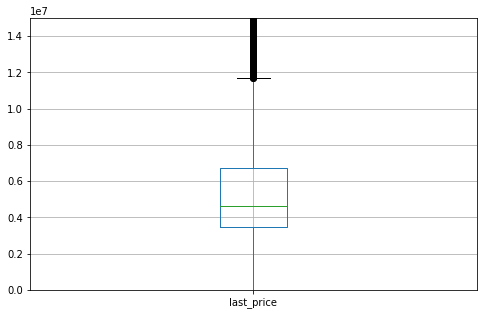

In [252]:
plot = data.boxplot('last_price', figsize=(8, 5))
lim = plot.set_ylim(0, 15000000)

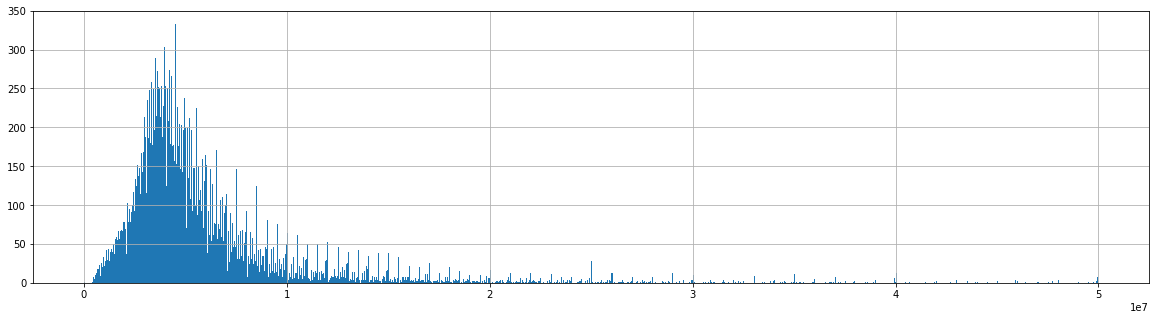

In [253]:
data['last_price'].hist(bins=1000, range=(0, 50000000), figsize=(20, 5))

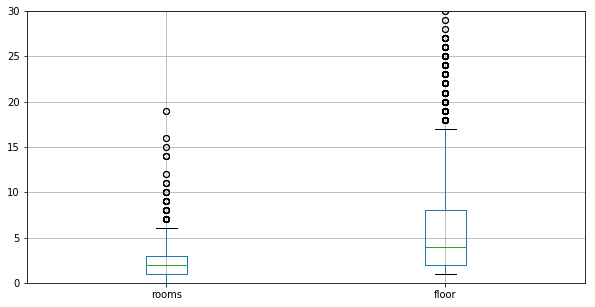

In [254]:
params_for_p = ['rooms', 'floor']
for parameter in params_for_p:
    plot = data.boxplot(params_for_p, figsize=(10, 5))
    lim = plot.set_ylim(0, 30)

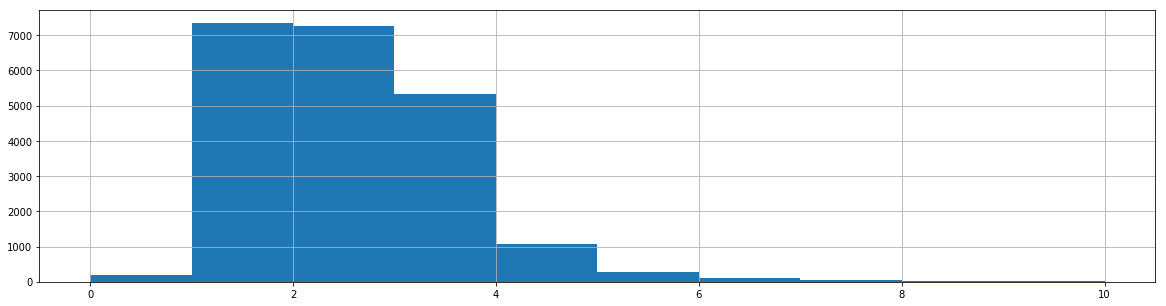

In [255]:
data['rooms'].hist(bins=10, range=(0, 10), figsize=(20, 5))

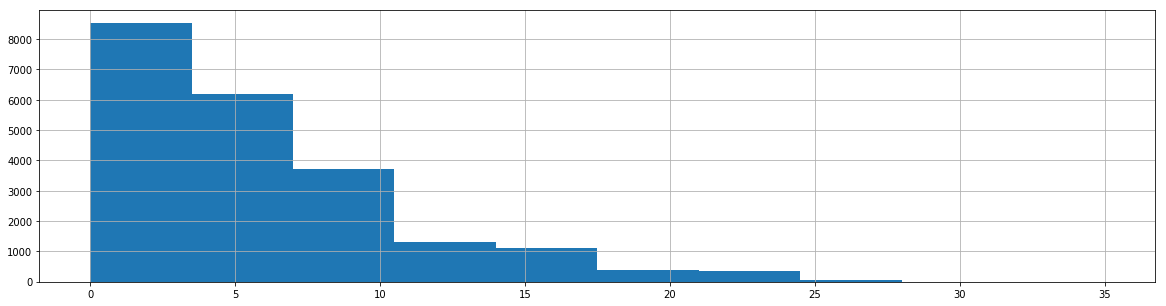

In [256]:
data['floor'].hist(bins=10, range=(0, 35), figsize=(20, 5))

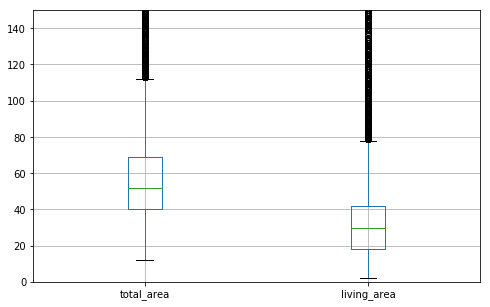

In [257]:
params_for_p1 = ['total_area', 'living_area']
for parameter in params_for_p1:
    plot = data.boxplot(params_for_p1, figsize=(8, 5))
    lim = plot.set_ylim(0, 150)

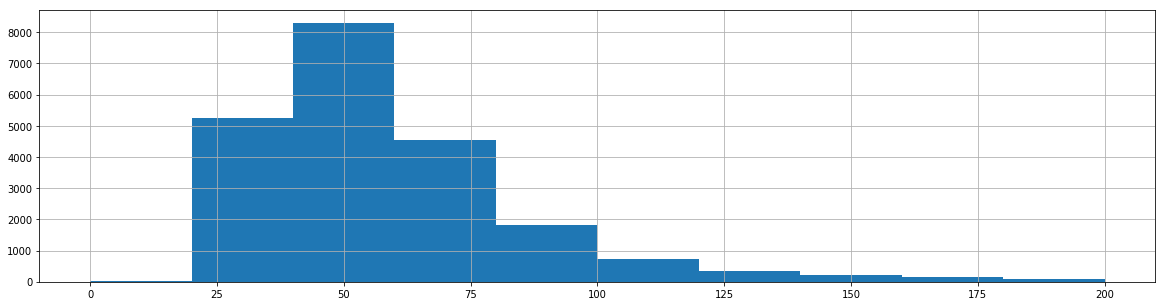

In [258]:
data['total_area'].hist(bins=10, range=(0, 200), figsize=(20, 5))

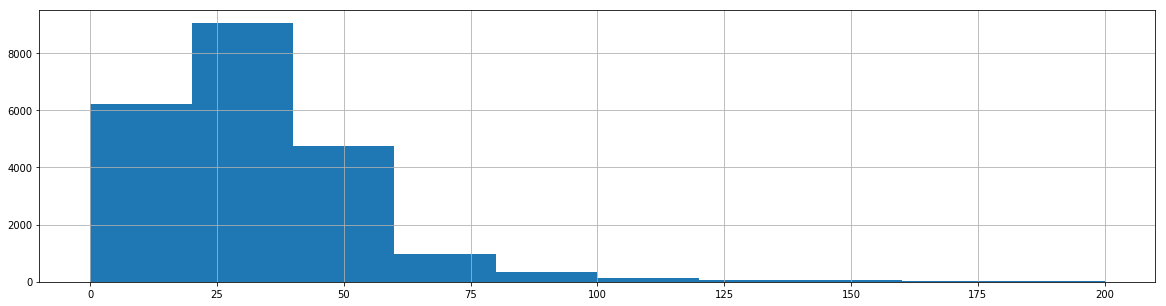

In [259]:
data['living_area'].hist(bins=10, range=(0, 200), figsize=(20, 5))

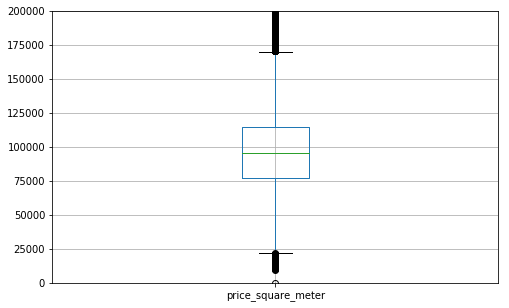

In [260]:
plot = data.boxplot('price_square_meter', figsize=(8, 5))
lim = plot.set_ylim(0, 200000)

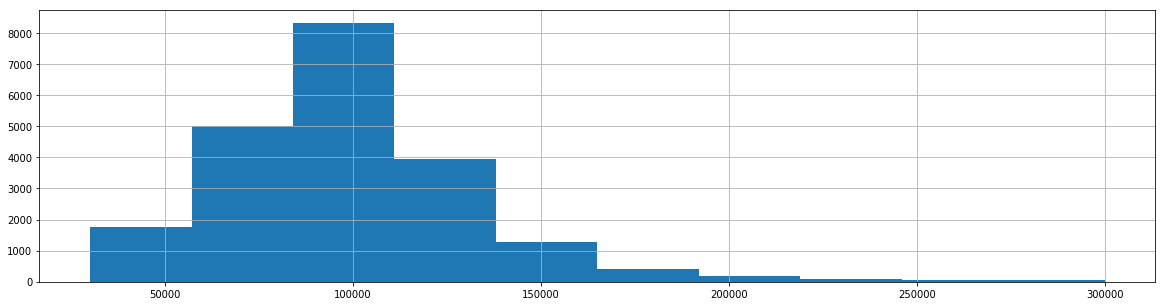

In [261]:
data['price_square_meter'].hist(bins=10, range=(30000, 300000), figsize=(20, 5))

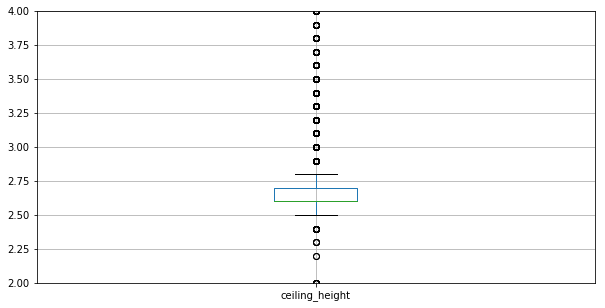

In [262]:
plot = data.boxplot('ceiling_height', figsize=(10, 5))
lim = plot.set_ylim(2, 4)

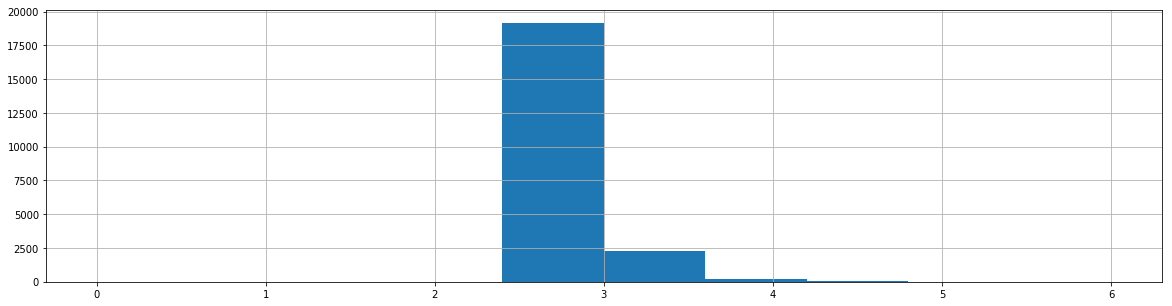

In [263]:
data['ceiling_height'].hist(bins=10, range=(0, 6), figsize=(20, 5))

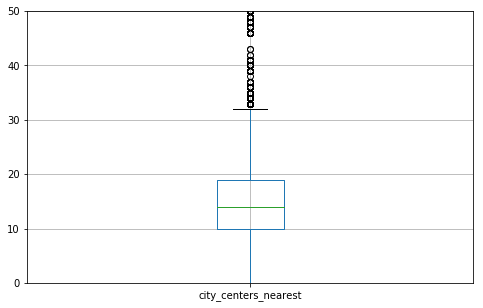

In [264]:
plot = data.boxplot('city_centers_nearest', figsize=(8, 5))
lim = plot.set_ylim(0, 50)

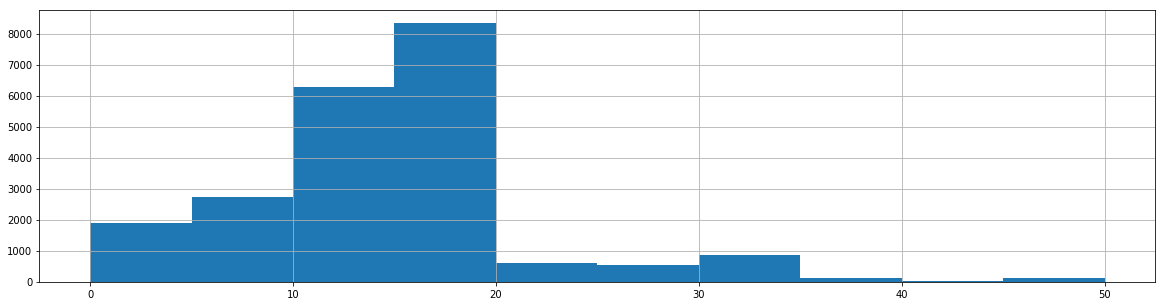

In [265]:
data['city_centers_nearest'].hist(bins=10, range=(0, 50), figsize=(20, 5))

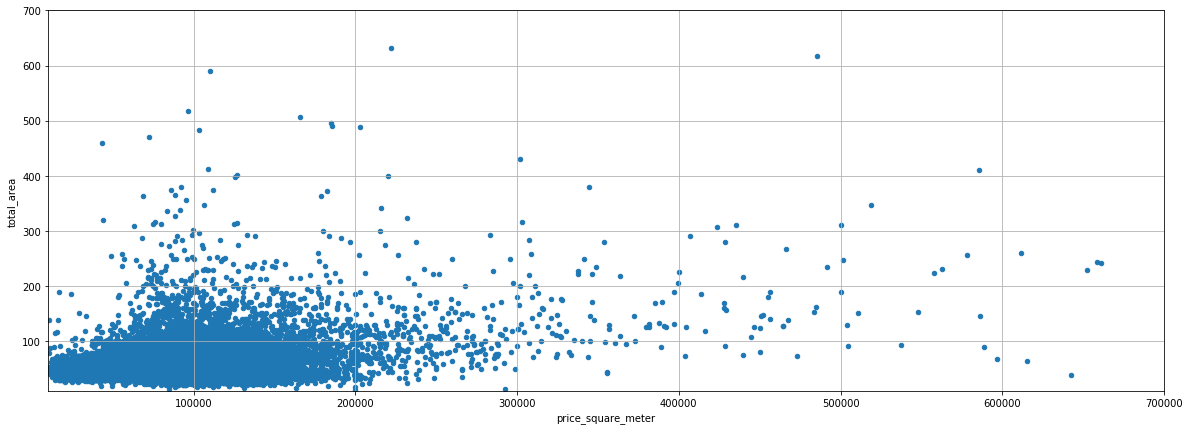

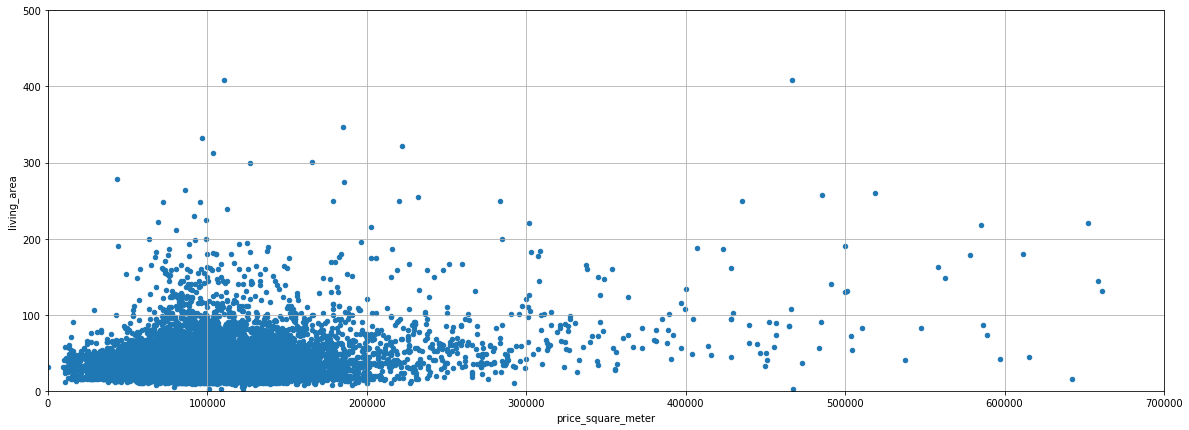

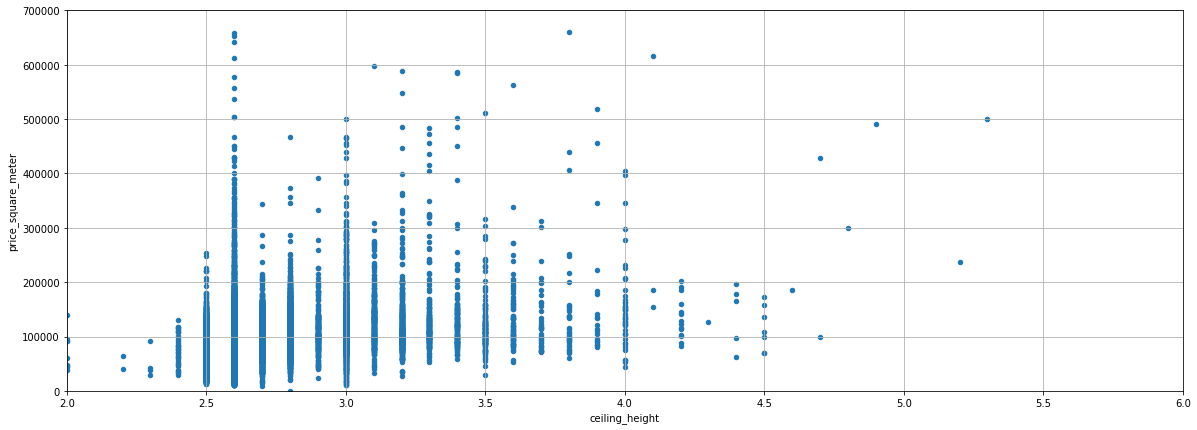

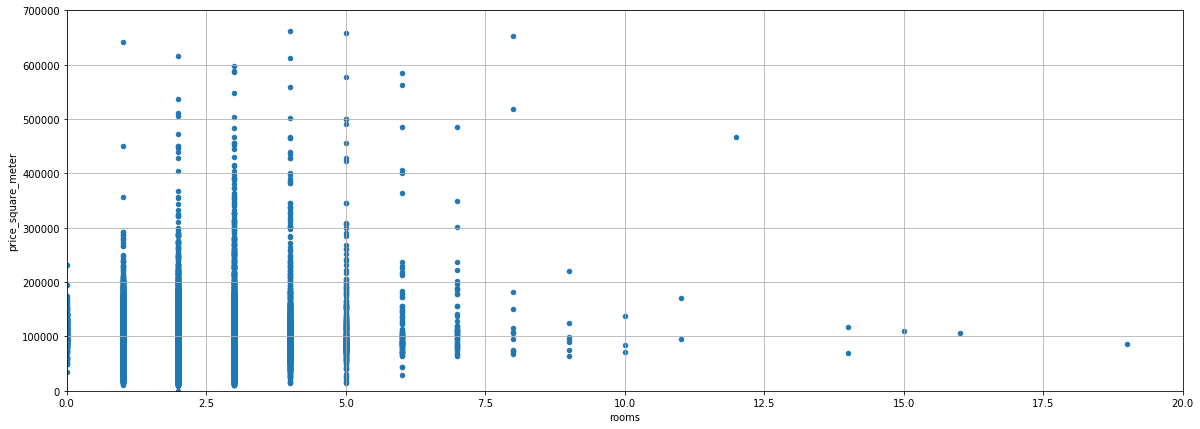

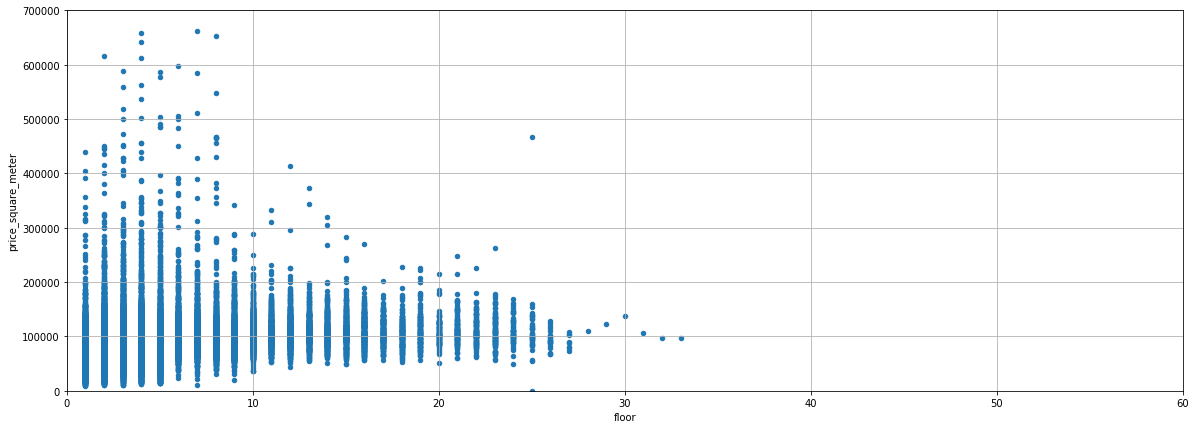

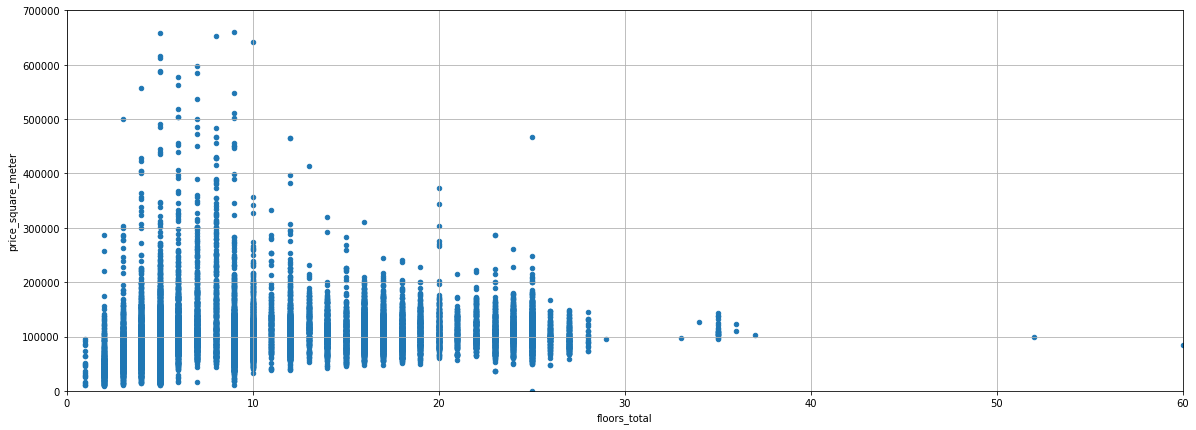

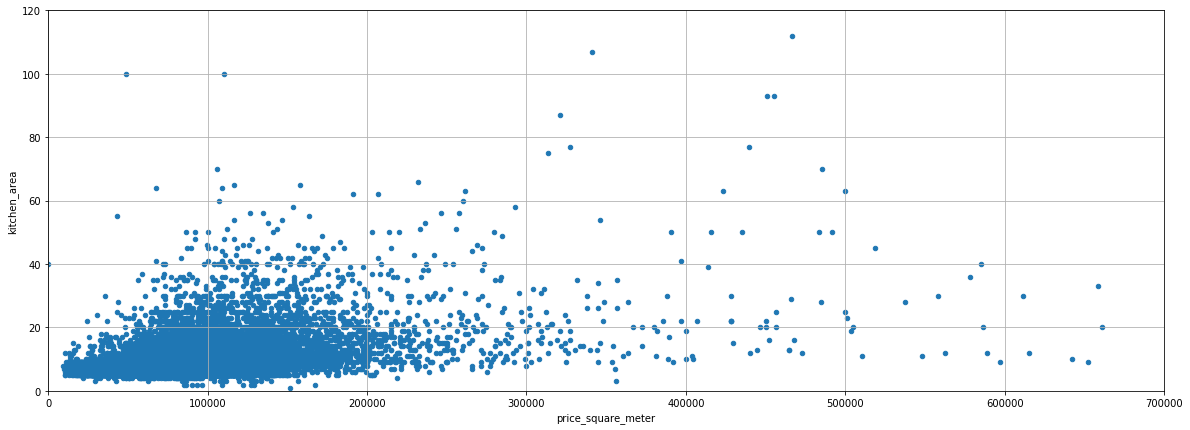

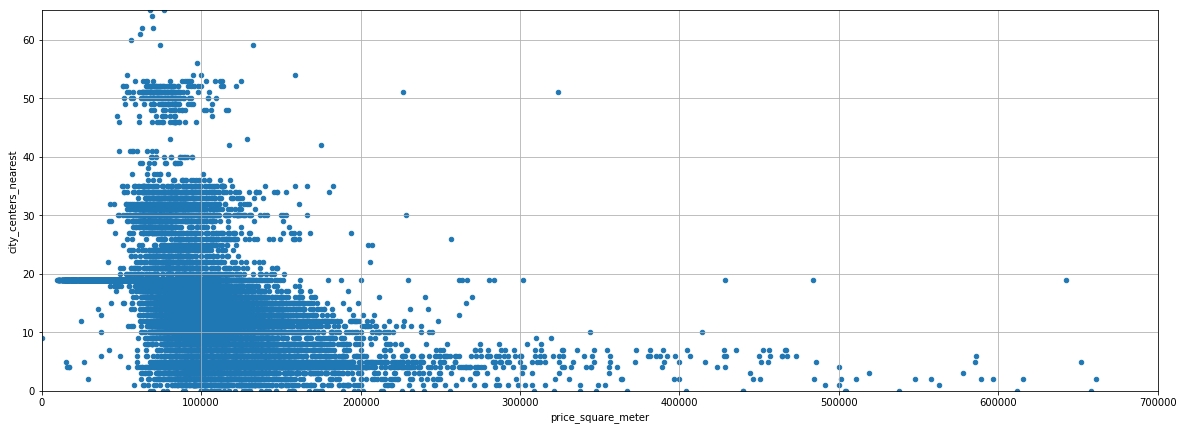

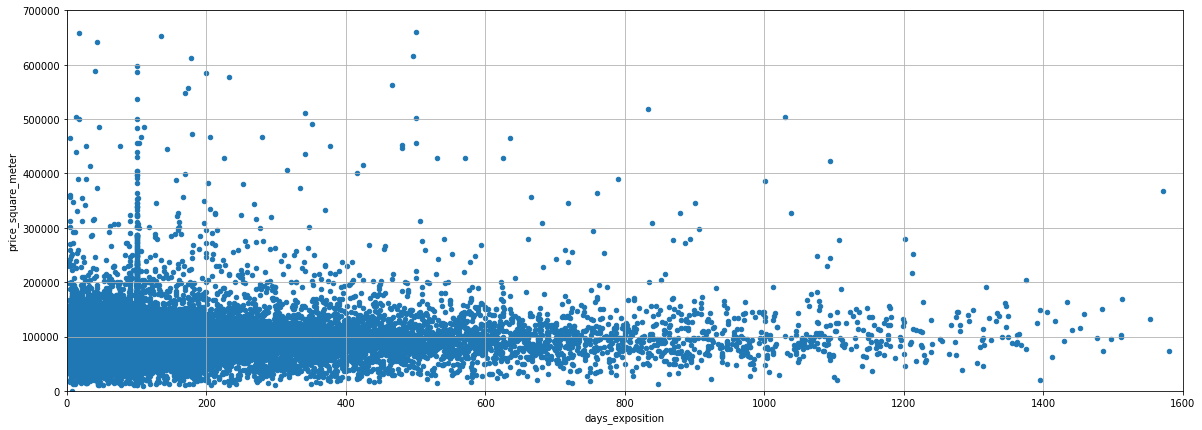

In [266]:
#выделим группу столбцов с наиболее важными параметрами для постройки графиков:

parameters_chart = data[['locality_name', 'last_price', 'price_square_meter', 'total_area', 'living_area', 'ceiling_height', 'rooms', 'floor', 'floors_total', 'option_floor', 'kitchen_area', 'city_centers_nearest', 'days_exposition', 'public_weekday', 'public_month', 'public_year']]
   
    
parameters_chart.plot(x='price_square_meter', y='total_area', xlim=(10000, 700000), ylim=(10, 700), kind='scatter', grid=True, figsize=(20, 7))
parameters_chart.plot(x='price_square_meter', xlim=(0, 700000), y='living_area', ylim=(0, 500), kind='scatter', grid=True, figsize=(20, 7))
parameters_chart.plot(y='price_square_meter', ylim=(0, 700000), x='ceiling_height', xlim=(2, 6), kind='scatter', grid=True, figsize=(20, 7))
parameters_chart.plot(y='price_square_meter', ylim=(0, 700000), x='rooms', xlim=(0, 20), kind='scatter', grid=True, figsize=(20, 7))
parameters_chart.plot(y='price_square_meter', ylim=(0, 700000), x='floor', xlim=(0, 60), kind='scatter', grid=True, figsize=(20, 7))
parameters_chart.plot(y='price_square_meter', ylim=(0, 700000), x='floors_total', xlim=(0, 60), kind='scatter', grid=True, figsize=(20, 7))
parameters_chart.plot(x='price_square_meter', xlim=(0, 700000), y='kitchen_area', ylim=(0, 120), kind='scatter', grid=True, figsize=(20, 7))
parameters_chart.plot(x='price_square_meter', xlim=(0, 700000), y='city_centers_nearest', ylim=(0, 65), kind='scatter', grid=True, figsize=(20, 7))
parameters_chart.plot(y='price_square_meter', ylim=(0, 700000), x='days_exposition', xlim=(0, 1600), kind='scatter', grid=True, figsize=(20, 7))

* Из графиков выявлен ряд естественных взаимосвязей: чем выше цена за кв.м тем больше общая и жилая площадь жилья, в более высоких домах квартиры дешевле, основная масса жилья это метраж до 130 кв.м (жилая до 80 кв.м) стоимостью до 170000 р/кв.м, выделяются потолки 2.6 и 3 м вероятно из-за типового размера, трехкомнатные квартиры дороже всего, стоимость выше за дома до 10 этажей, ну и конечно близость к центру удорожает квадратный метр.

### 2.2. Выясним сколько в среднем длится процесс продажи. <a id='102101'></a>
**********************
    *методом describe посмотрим средние показатели, и построим гистограмму для наглядности*

count    21668.000000
mean       173.292274
std        207.712189
min          1.000000
25%         48.000000
50%        101.000000
75%        204.000000
max       1580.000000
Name: days_exposition, dtype: float64


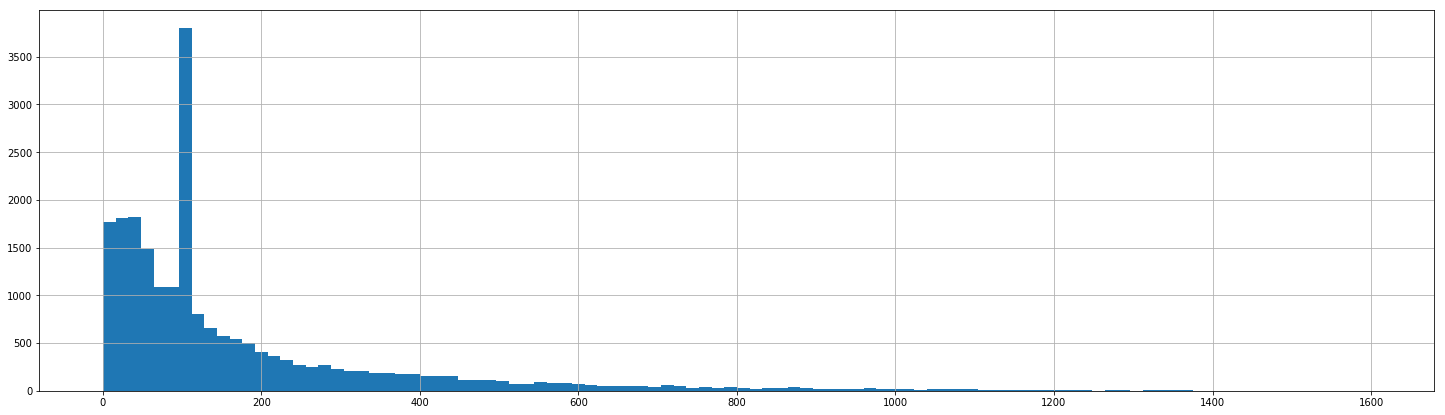

In [267]:
data['days_exposition'].hist(bins=100, range=(0, 1600), figsize=(25, 7))

print(data['days_exposition'].describe())

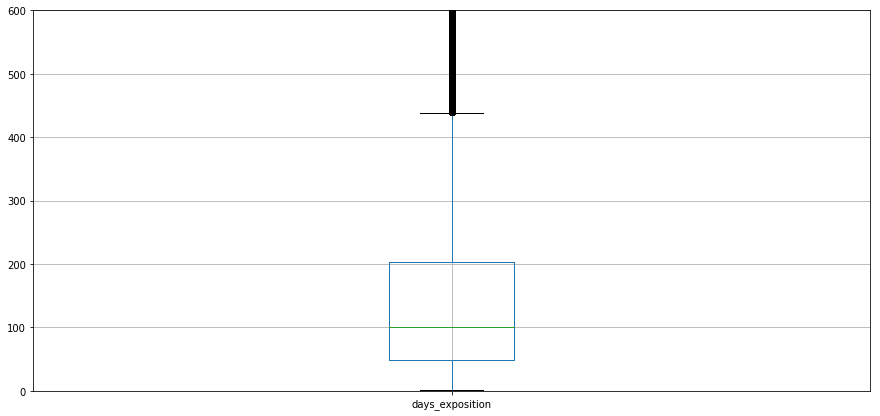

In [268]:
plot = data.boxplot('days_exposition', figsize=(15, 7))
lim = plot.set_ylim(0, 600)

Теперь можно сказать какие параметры имеют большинство квартир:
* цена до 11500000 руб.;
* комнаты от 1 до 6;
* до 17-го этажа;
* общая площадь от 15 до 120 метров, жилая от 0 до 80 метров;
* цена квадратного метра от 23000 до 170000 руб;
* высота потолков от 2,5 м до 2,8 метров;
* расстояние от центра - до 32 км.
* процесс продажи длится в среднем 100 дней до 450 дней.
********************
*Сделаем таблицу по этим параметрам:*

In [269]:
day_corr = data.pivot_table(index='locality_name', values=['days_exposition', 'last_price', 'total_area', 'city_centers_nearest'])
day_corr.corr()

,city_centers_nearest,days_exposition,last_price,total_area
city_centers_nearest,1.000000,0.143785,0.336564,0.082862
days_exposition,0.143785,1.000000,0.045496,0.025207
last_price,0.336564,0.045496,1.000000,0.683121
total_area,0.082862,0.025207,0.683121,1.000000


### 2.3. Выявим особенности. <a id='102102'></a>

In [270]:
usual_p1 = data.query('last_price < 11500000' and 'ceiling_height < 2.8' and 'total_area < 120' and 'rooms < 6' and 'floor < 17' and 'living_area < 80' and 'price_square_meter < 170000' and 'city_centers_nearest < 32' and 'days_exposition < 450')
usual_param = usual_p1.query('rooms > 1' and 'total_area > 15' and 'price_square_meter > 23000' and 'ceiling_height > 2.5')
usual_param.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,public_weekday,public_month,public_year,price_square_meter,ratio_square,ratio_kitchen
count,16323.000000,1.632300e+04,16323.000000,16323.000000,16323.000000,16323.000000,16323.000000,16323.000000,16323.000000,16323.000000,16323.000000,16323.000000,16323.000000,16323.000000,16323.000000,16323.000000,16323.000000,16323.000000,16323.000000,16323.000000,1.632300e+04,16323.000000,16323.000000
mean,10.129694,6.787282e+06,61.098756,2.055505,2.713472,11.289346,34.515346,6.193776,10.675121,0.631502,27.570973,14.685168,0.474545,168.130797,0.613061,205.233290,120.708448,2.565644,6.444771,2017.452429,1.021632e+05,0.554502,0.191353
std,5.744608,1.167091e+07,35.846761,1.095202,0.221883,6.864329,22.757488,5.092961,5.824876,0.985823,10.900033,7.755322,0.754035,308.854650,0.899158,308.017878,103.228970,1.784603,3.456851,0.927391,5.124850e+04,0.107749,0.077300
min,0.000000,1.219000e+04,12.000000,0.000000,2.600000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,2014.000000,1.110000e+02,0.020000,0.020000
25%,6.000000,3.550000e+06,40.000000,1.000000,2.600000,5.000000,18.000000,2.000000,8.000000,0.000000,20.000000,10.000000,0.000000,0.000000,0.000000,0.000000,45.000000,1.000000,3.000000,2017.000000,7.916600e+04,0.480000,0.130000
50%,10.000000,4.830000e+06,53.000000,2.000000,2.600000,9.000000,30.000000,5.000000,9.000000,0.000000,26.000000,14.000000,0.000000,0.000000,0.000000,0.000000,101.000000,3.000000,6.000000,2017.000000,9.714200e+04,0.560000,0.180000
75%,14.000000,7.100000e+06,71.000000,3.000000,2.800000,16.000000,43.000000,8.000000,12.000000,1.000000,33.000000,19.000000,1.000000,300.000000,1.000000,405.000000,160.000000,4.000000,10.000000,2018.000000,1.166660e+05,0.630000,0.240000
max,50.000000,7.630000e+08,900.000000,19.000000,5.300000,60.000000,409.000000,33.000000,112.000000,5.000000,81.000000,62.000000,3.000000,3190.000000,3.000000,1344.000000,449.000000,6.000000,12.000000,2019.000000,1.907500e+06,1.000000,0.790000


In [271]:
data.describe(include=['object', 'bool'])

,is_apartment,studio,open_plan,locality_name,option_floor
count,21668,21668,21668,21668,21668
unique,3,2,2,312,3
top,False,False,False,Санкт-Петербург,Другие
freq,19039,21530,21607,14514,15941


Выводы:
* По всей таблице разница между средним и медианой уменьшилась, т.е. таблица без выбросов стала ближе к реальным средним показателям.
* например - цена по рынку изменилась с 6,49 млн.р.(среднее) - 4,65 млн.р.(медиана) до 5,27 к 5;
* двушка площадью 60 м и жилой 35 м, с высотой потолка 2,6 м, на 4-5 этаже, от центра города в 15 км, продающаяся в среднем за 100-120 дней.

### 2.4. Какие факторы больше всего влияют на стоимость квартиры? <a id='102103'></a>

In [272]:
rep1 = usual_param.corr()[['last_price', 'price_square_meter']]

rep1.query('abs(last_price) > 0.5 or abs(price_square_meter) > 0.5').sort_values(by = 'last_price', ascending = False)

,last_price,price_square_meter
last_price,1.000000,0.747869
price_square_meter,0.747869,1.000000
total_area,0.627927,0.296798
living_area,0.554138,0.223190


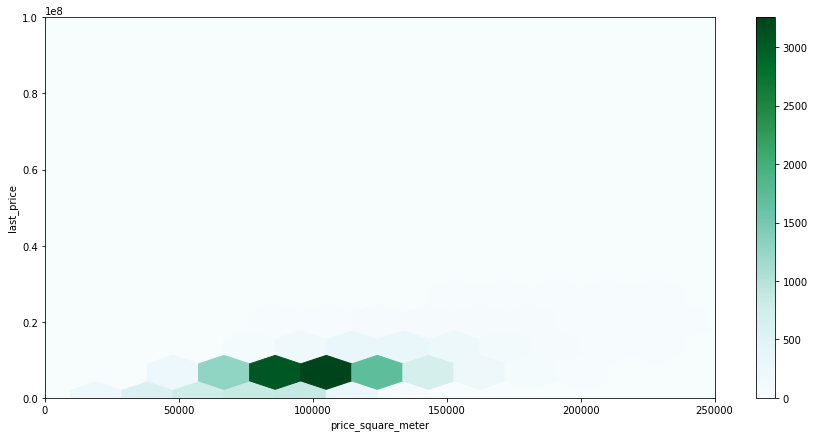

In [273]:
plot = usual_param.plot(x = 'price_square_meter',
                        y = 'last_price',
                        kind = 'hexbin',
                        sharex = False,
                        figsize = (15, 7))
lim = plot.set_xlim(0, 250000)
lim = plot.set_ylim(0, 1e8)

* большинство объявлений групируются в районе 80000 - 115000 за квадратный метр и между 3 и 4 миллионами рублей полной стоимости

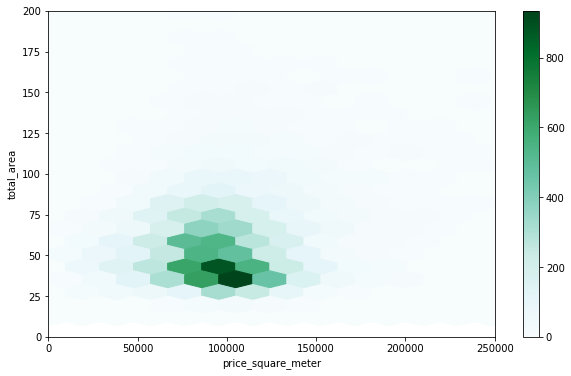

In [274]:
plot = usual_param.plot(x = 'price_square_meter',
                        y = 'total_area',
                        kind = 'hexbin',
                        sharex = False,
                        figsize = (10, 6))
lim = plot.set_xlim(0, 250000)
lim = plot.set_ylim(0, 200)

* Связь между ценой квадратного метра и общей площадью есть, но цена не растет (больше всего объявлений в районе 25-60 метров в диапазоне цен за кв.м от 70 до 125 тысяч), видимо есть другие факторы которые влияют на цену, например удаленность от центра и количество комнат.

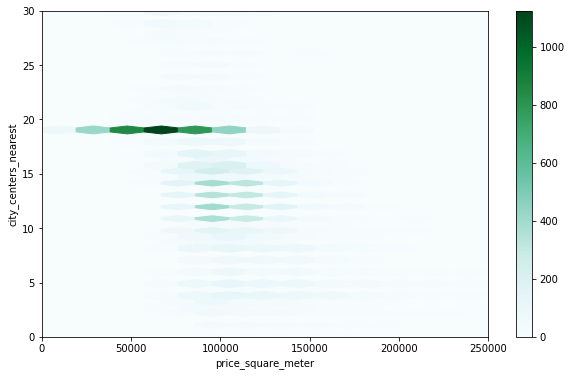

In [275]:
plot = usual_param.plot(x = 'price_square_meter',
                        y = 'city_centers_nearest',
                        kind = 'hexbin',
                        sharex = False,
                        figsize = (10, 6))
lim = plot.set_xlim(0, 250000)
lim = plot.set_ylim(0, 30)

* Связи между ценой квадратного метра и удаленностью от центра особенной не вижу, но выделяется отрезок на 19 километре, видимо один или несколько районов, где ведется активное строительство, (цена за метр от 40000 до 95000) и очень много предложений. Скорее видно, что с удалением от центра разброс цен за кв.м. уменьшается, если с 0 по 10 километр диапазон очень большой (примерно от 80 тыс. за кв.м до 160 тыс.), с 10 по 18 км больше предложений, но и диапазон цен меньше (от 80 до 140), в области предложений мало.

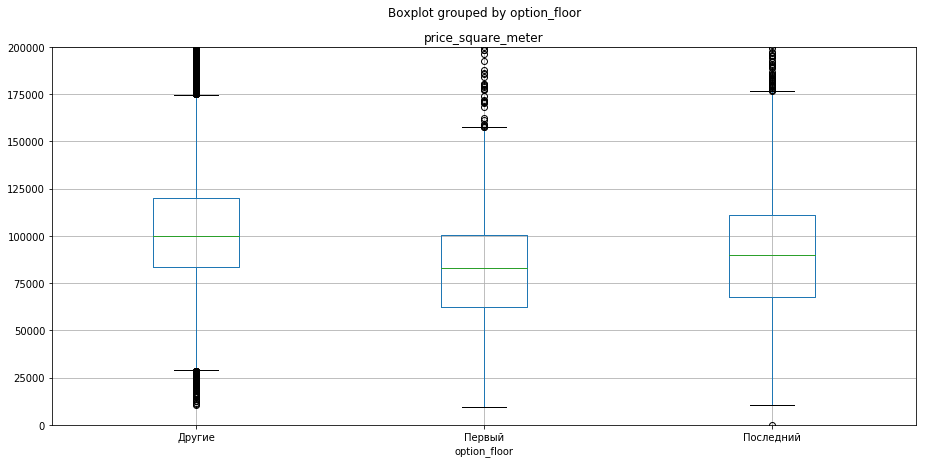

In [276]:
plot = usual_param.boxplot('price_square_meter', by = 'option_floor', figsize=(15, 7))
lim = plot.set_ylim(0, 200000)

### 2.5. Факторы влияющие на цену квадратного метра. <a id='102104'></a>

График зависимости цены за кв.метр от этажа.

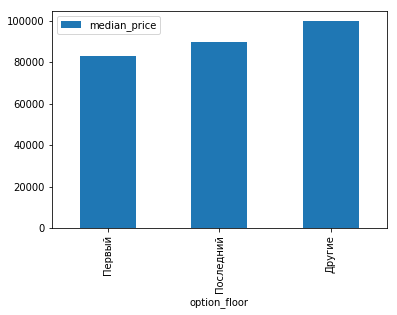

In [277]:
usual_p = usual_param.pivot_table(index='option_floor', values='price_square_meter', aggfunc=['median', 'count'])
usual_p.columns = ['median_price', 'floors']
usual_p.sort_values('median_price').plot(y='median_price', kind='bar')

Ниже всего стоимость квартир на первом этаже, следом идут последние этажи. Вывод - все хотят жить посередине)).

******************
График зависимости цены за кв.метр от количества комнат.

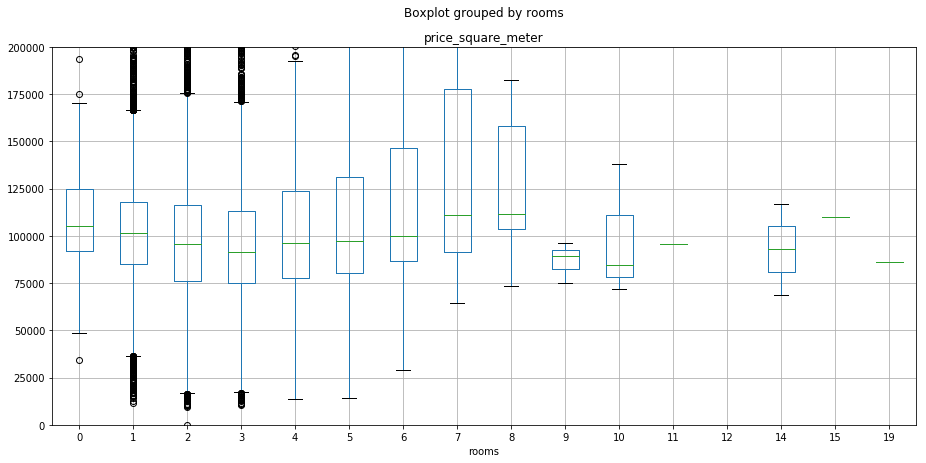

In [278]:
plot = usual_param.boxplot('price_square_meter', by = 'rooms', figsize=(15, 7))
lim = plot.set_ylim(0, 200000)

Медианная цена за кв.м. 10-комнатных ниже всех, но это скорее исключение. Среди обычных квартир ниже всего медианная цена на 3-х комнатные квартиры, дороже 2-х и 4-5 комнатные и еще дороже 1 и 6 комнатные и выше них квартиры без комнат.

График зависимости цены за кв.метр от близости к центру.

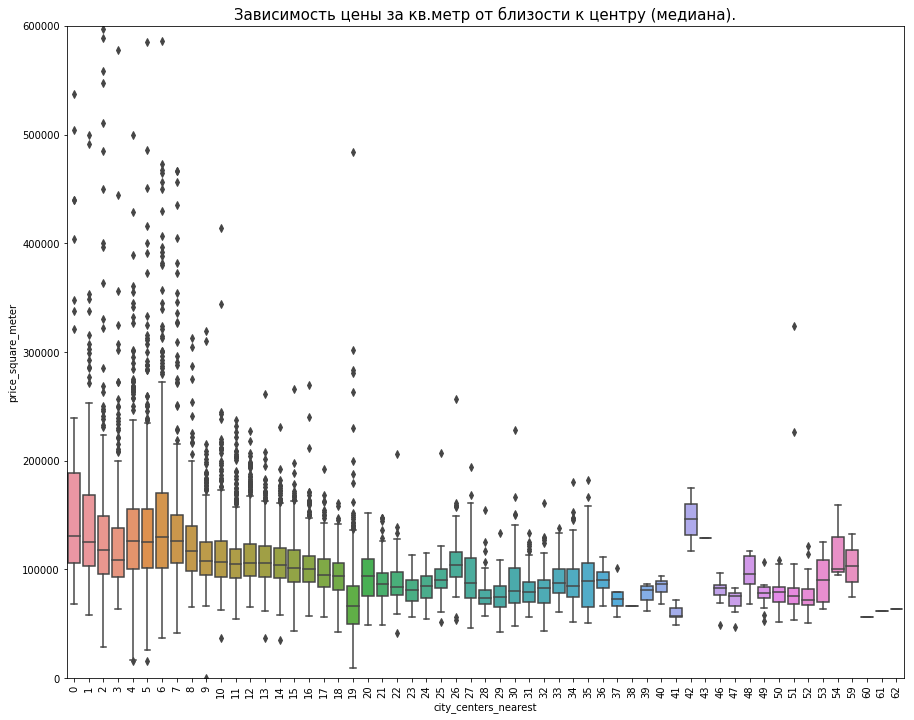

In [279]:
plt.figure(figsize=(15, 12))
sns.boxplot(x='city_centers_nearest', y='price_square_meter', data=usual_param)
plt.ylim(0, 600000)
plt.title('Зависимость цены за кв.метр от близости к центру (медиана).', fontsize=15) 
plt.xticks(rotation=90)
plt.show()

График зависимости цены за кв.метр от дня недели, месяца и года, когда квартира была выставлена на продажу.

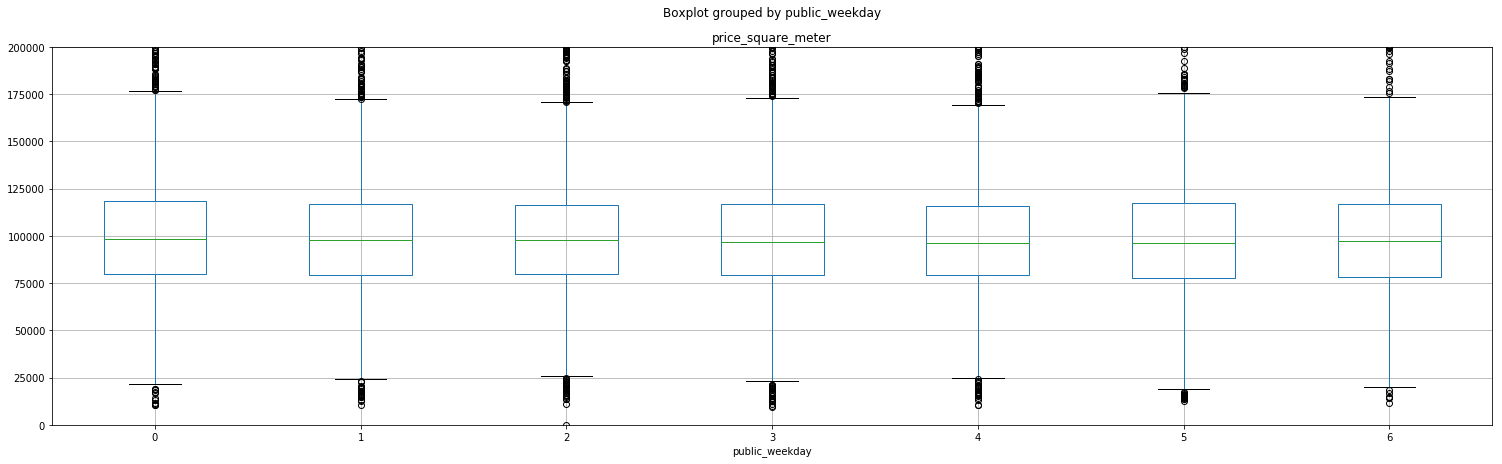

In [280]:
plot = usual_param.boxplot('price_square_meter', by = 'public_weekday', figsize=(25, 7))
lim = plot.set_ylim(0, 200000)

В целом особенной связи между ценой кв.м и днем недели не наблюдается, минимальное снижение в середине недели.

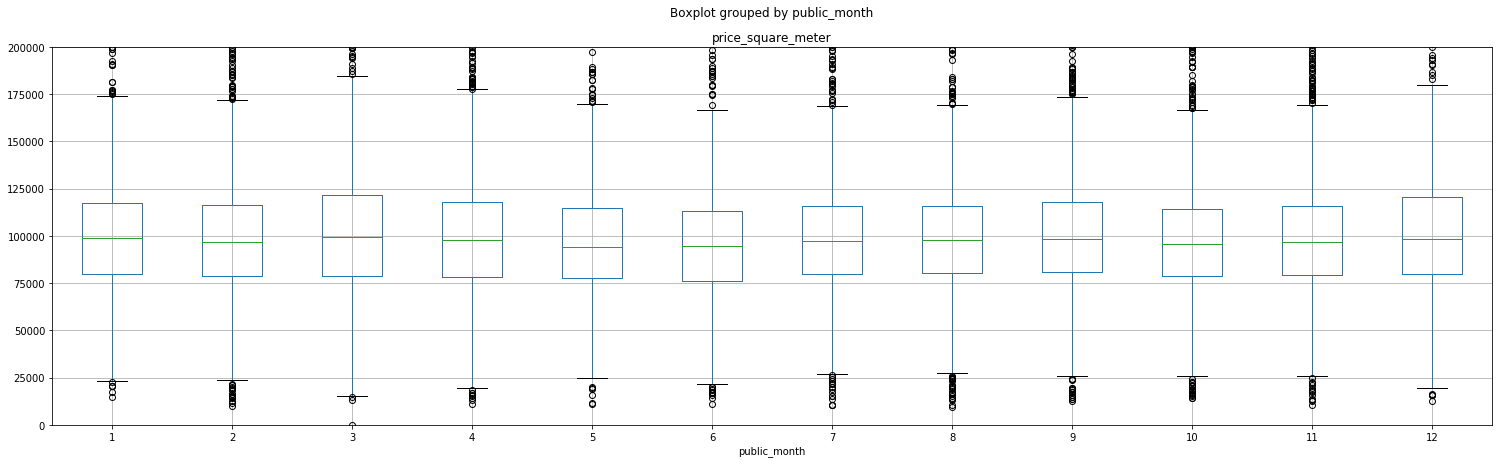

In [281]:
plot = usual_param.boxplot('price_square_meter', by = 'public_month', figsize=(25, 7))
lim = plot.set_ylim(0, 200000)

Ниже всего цена кв.м в мае и июне. Выше всего цены в марте.

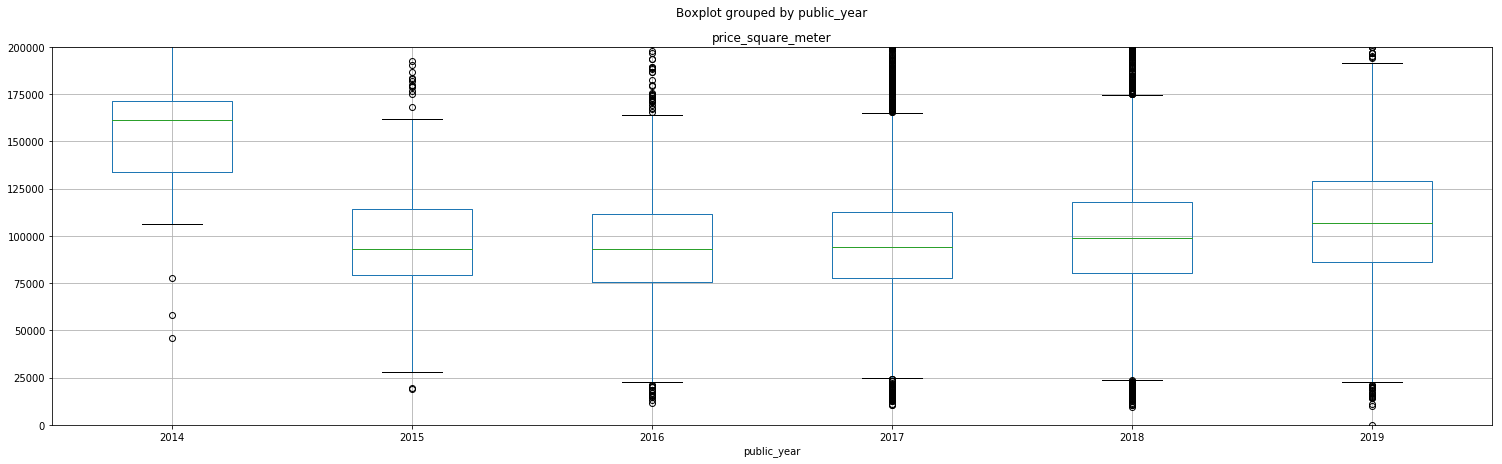

In [282]:
plot = usual_param.boxplot('price_square_meter', by = 'public_year', figsize=(25, 7))
lim = plot.set_ylim(0, 200000)

Самые высокие цены за кв/м были в 2014 году, резкое падение в 2015, с 2015 по 2017 включительно на том же уровне и с 2018 начался рост.

### 2.6. Что можно сказать о цене квадратного метра в пригородах?  <a id='102105'></a>

*Сделаем срез пригорода методом исключения Санкт_Петербурга и двух районов внутри КАД непосредственно прилегающих к городу (Парголово и Кудрово, т.к. эти районы дублируются по своим старым названиям), чтобы точнее разграничить город и область по цене*

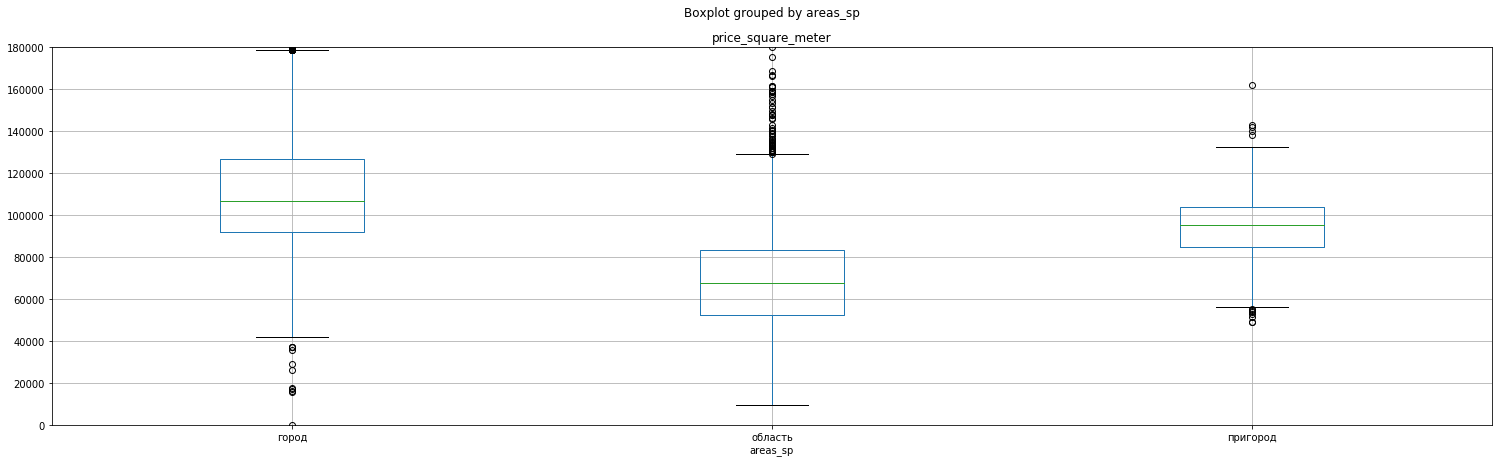

In [283]:
usual_param['areas_sp'] = 'область'
usual_param.loc[usual_param['locality_name'] == 'Петергоф', 'areas_sp'] = 'город'
usual_param.loc[usual_param['locality_name'] == 'Санкт-Петербург', 'areas_sp'] = 'город'
usual_param.loc[usual_param['locality_name'] == 'Парголово', 'areas_sp'] = 'пригород'
usual_param.loc[usual_param['locality_name'] == 'поселок Парголово', 'areas_sp'] = 'пригород'
usual_param.loc[usual_param['locality_name'] == 'Кудрово', 'areas_sp'] = 'пригород'
usual_param.loc[usual_param['locality_name'] == 'деревня Кудрово', 'areas_sp'] = 'пригород'

#проверим:
#print(usual_param['areas_sp'].head(10))

plot = usual_param.boxplot('price_square_meter', by = 'areas_sp', figsize=(25, 7))
lim = plot.set_ylim(0, 180000)

Самая высокая цена за кв.м в городе, немного ниже в ближайших районах, и в области самые низкие цены, причем разница с городом почти на 30%.

### 2.7. Выделим крупные сегменты типичных квартир в центре и вне центра, сравним корреляцию основных факторов с ценой.  <a id='102106'></a>

*Выделим сегмент типичных квартир в центре (в пределах 11 км) и вне центра, и посмотрим, типичные параметры для них:*

In [284]:
center = usual_param.query('city_centers_nearest <= 11')
print('Количество объявлений о продаже квартир в центре города:', len(center))
near = usual_param.query('city_centers_nearest > 11')
print('Количество объявлений о продаже квартир в пригороде:', len(near))

Количество объявлений о продаже квартир в центре города: 5220
Количество объявлений о продаже квартир в пригороде: 11103


In [285]:
report = center.corr()[['last_price', 'price_square_meter']]

#здесь нас интересует мощность корреляции, а не знак, поэтому фильтруем по модулю коэфф. корреляции
report.query('abs(last_price) > 0.5 or abs(price_square_meter) > 0.5').sort_values(by = 'last_price', ascending = False)

,last_price,price_square_meter
last_price,1.000000,0.793777
price_square_meter,0.793777,1.000000
total_area,0.628287,0.296320
living_area,0.547984,0.219160


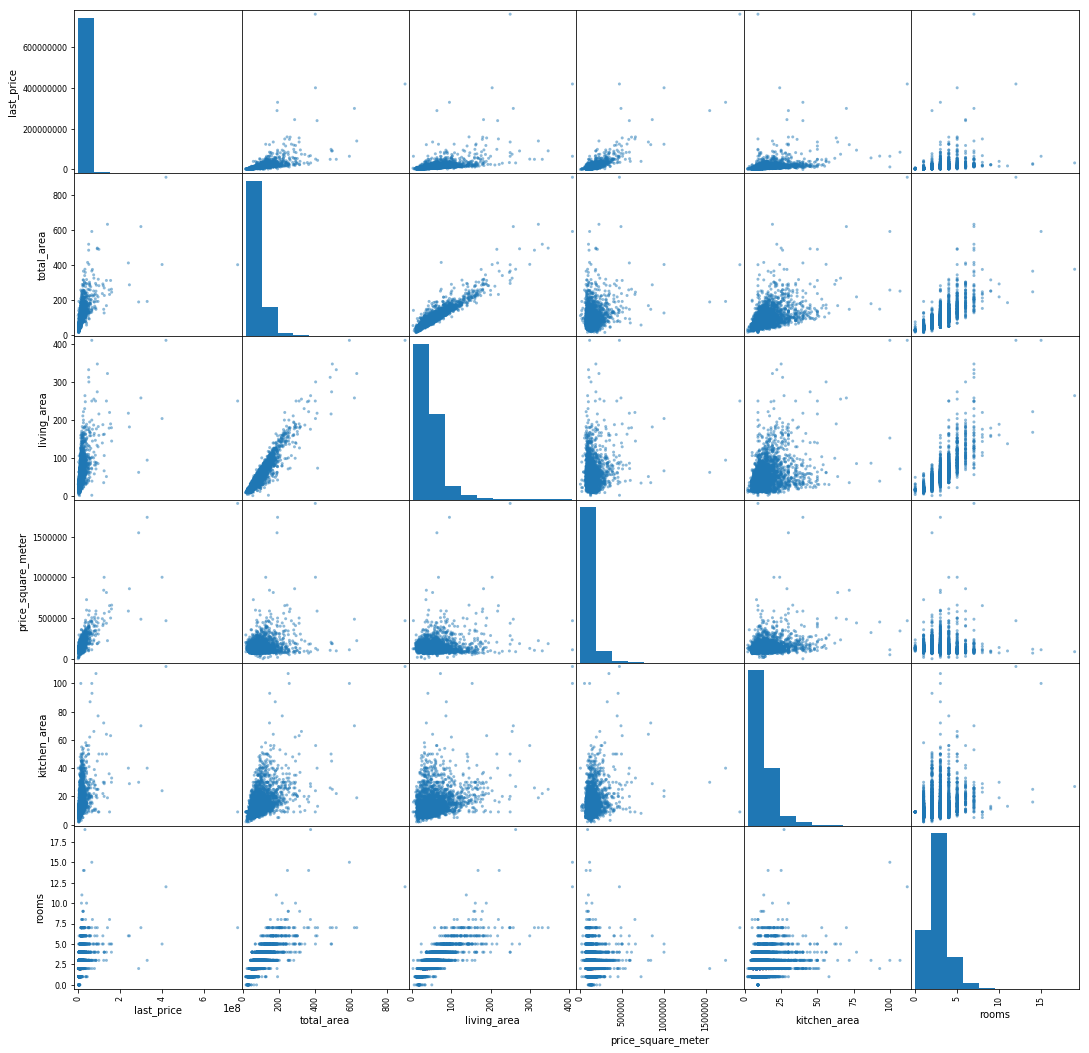

In [286]:
plot = pd.plotting.scatter_matrix(center[['last_price', 'total_area','living_area', 'price_square_meter', 'kitchen_area', 'rooms']], figsize=(18,18))

In [287]:
report2 = near.corr()[['last_price', 'price_square_meter']]
report2.query('abs(last_price) > 0.5 or abs(price_square_meter) > 0.5').sort_values(by = 'last_price', ascending = False)

,last_price,price_square_meter
last_price,1.000000,0.581324
total_area,0.755812,0.033063
living_area,0.629051,-0.069622
price_square_meter,0.581324,1.000000
kitchen_area,0.559526,0.277139


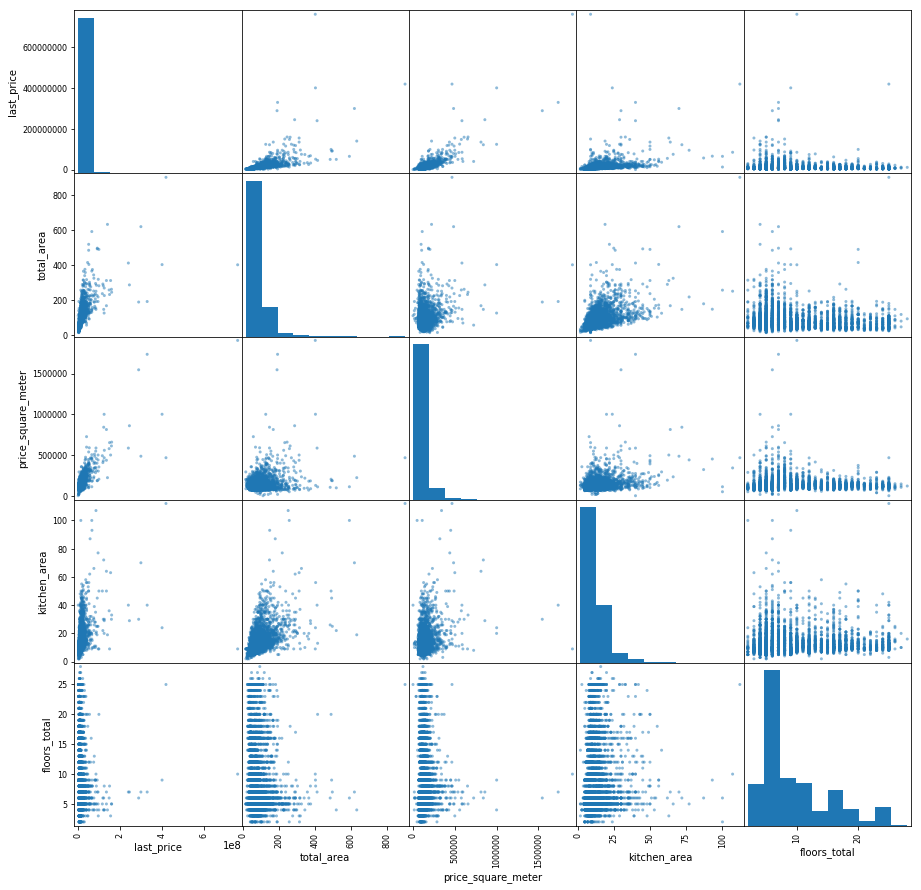

In [288]:
plot = pd.plotting.scatter_matrix(center[['last_price', 'total_area', 'price_square_meter', 'kitchen_area', 'floors_total']], figsize=(15,15))

У квартир в центре города наибольшая зависимость наблюдается у общей цены и цены за кв. м.(0,79), в пригороде же эта связь ниже(0,58), так же двольно сильна связь общей цены и общей площади квартиры, но в пригороде эта связь сильнее (0,75).

### 2.8. Выявим наиболее характерные параметры для апартаментов, студий, квартир свободной планировки, влияют ли они на цену? Сравним со схожими параметрами типовой планировки.  <a id='102107'></a>

In [289]:
apart = data.query('is_apartment == True')
apart_data = usual_param.query('price_square_meter in @apart.index')
print('Количество объявлений о продаже апартаментов попавших в таблицу без выбросов:', len(apart_data))
print(apart.median())

report3 = apart.corr()[['last_price', 'price_square_meter']]
report3.query('abs(last_price) > 0.5 or abs(price_square_meter) > 0.5').sort_values(by = 'last_price', ascending = False)

Количество объявлений о продаже апартаментов попавших в таблицу без выбросов: 0
total_images                 11.00
last_price              6900000.00
total_area                   58.00
rooms                         2.00
ceiling_height                3.00
floors_total                  5.00
living_area                  35.00
floor                         4.00
is_apartment                  1.00
studio                        0.00
open_plan                     0.00
kitchen_area                 11.00
balcony                       1.00
airports_nearest             27.00
city_centers_nearest         19.00
parks_around_3000             0.00
parks_nearest                 0.00
ponds_around_3000             1.00
ponds_nearest               217.00
days_exposition             101.00
public_weekday                2.00
public_month                  6.00
public_year                2018.00
price_square_meter       116129.00
ratio_square                  0.55
ratio_kitchen                 0.19
dtype: flo

,last_price,price_square_meter
last_price,1.000000,0.630503
total_area,0.872336,0.203942
living_area,0.849744,0.205467
kitchen_area,0.695211,0.352808
price_square_meter,0.630503,1.000000
rooms,0.601794,0.100556
days_exposition,0.584015,0.590546
parks_around_3000,0.512261,0.575277
ponds_around_3000,0.265032,0.704985
public_year,-0.659813,-0.657935


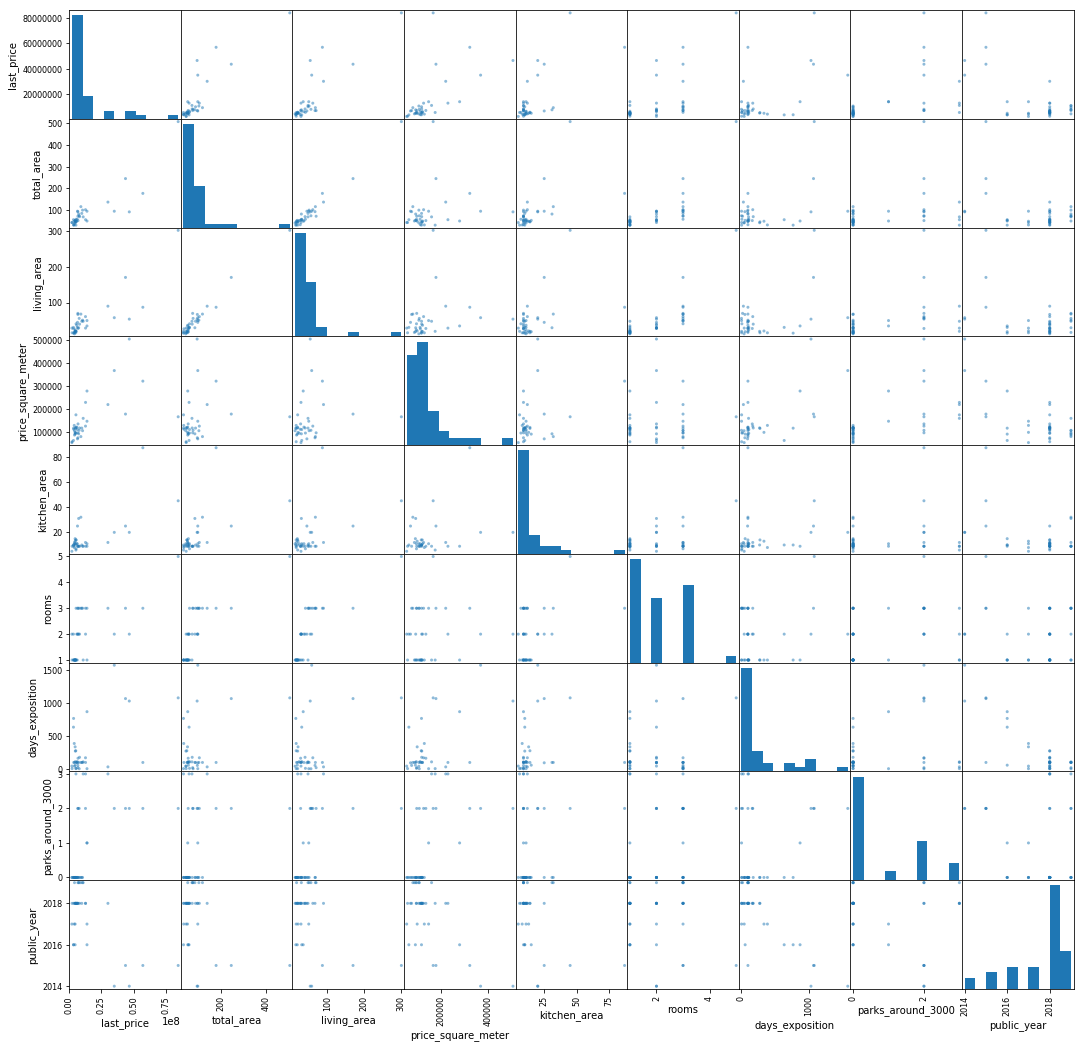

In [290]:
plot = pd.plotting.scatter_matrix(apart[['last_price', 'total_area','living_area', 'price_square_meter', 'kitchen_area', 'rooms', 'days_exposition', 'parks_around_3000', 'public_year']], figsize=(18,18))

Типичные апартаменты это двухкомнатная квартира площадью 58 метров с высотой потолков 3 метра, на 4 этаже 5-этажного дома с одним балконом, жилая площадь 55%, где кухня занимает 19% площади квартиры. Цена за квадратный метр 116129 руб. и общая стоимость 6,9 млн руб. На удалении от центра в среднем на 19 км. Скорее всего это квартиры в новостройках в присоединенных не так давно развивающихся районах. В среднем продается такая квартира за 101 день (возможно есть взаимосвязь с выбросом выше и просто эти значения были у апартаментов не заполнены).
***********
* На цену за апартаменты влияют: общая и жилая площадь, а так же площадь кухни, количество комнат, так же выявлена корреляция с ценой за квадратный метр и количеством дней продажи. Отрицательная корреляция с годом - не понимаю, что это значит?
* На цену за квадратный метр такого жилья влияют так же расстояние до парков и прудов, и есть корреляция с количеством дней продажи.

In [291]:
studio = data.query('studio == True')
studio_data = data.query('price_square_meter in @studio.index')
print('Количество объявлений о продаже студий попавших в таблицу без выбросов:', len(studio_data))
print(studio.median())

report4 = studio.corr()[['last_price', 'price_square_meter']]
report4.query('abs(last_price) > 0.5 or abs(price_square_meter) > 0.5').sort_values(by = 'last_price', ascending = False)

Количество объявлений о продаже студий попавших в таблицу без выбросов: 2
total_images                  7.00
last_price              2775000.00
total_area                   26.00
rooms                         0.00
ceiling_height                2.60
floors_total                 17.00
living_area                  18.00
floor                         7.00
studio                        1.00
open_plan                     0.00
kitchen_area                  9.00
balcony                       1.00
airports_nearest             26.00
city_centers_nearest         16.00
parks_around_3000             0.00
parks_nearest                 0.00
ponds_around_3000             0.00
ponds_nearest                 0.00
days_exposition              60.00
public_weekday                3.00
public_month                  7.00
public_year                2018.00
price_square_meter       108347.50
ratio_square                  0.68
ratio_kitchen                 0.35
dtype: float64


,last_price,price_square_meter
last_price,1.000000,0.603510
total_area,0.847181,0.125975
living_area,0.746607,0.125635
price_square_meter,0.603510,1.000000
city_centers_nearest,-0.547470,-0.599312
ratio_kitchen,-0.630323,-0.051347


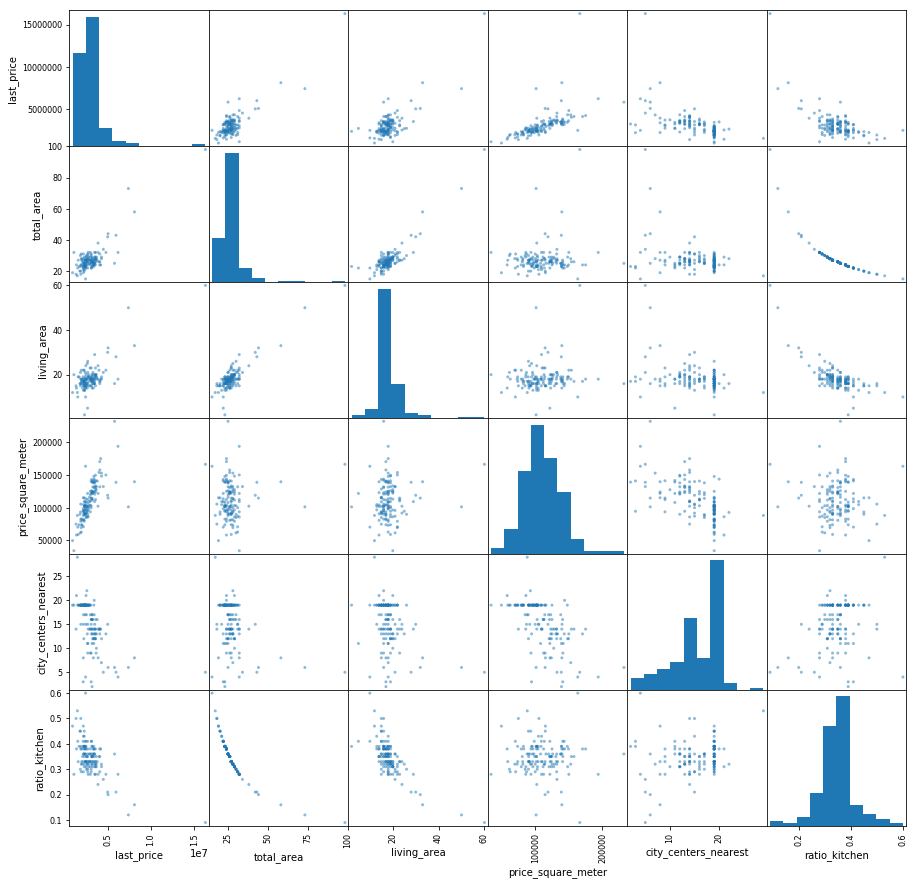

In [292]:
plot = pd.plotting.scatter_matrix(studio[['last_price', 'total_area','living_area', 'price_square_meter', 'city_centers_nearest', 'ratio_kitchen']], figsize=(15,15))

Типичная студия это квартира без комнат площадью 26 метров с высотой потолков 2,6 метра, на 7 этаже 17-этажного дома с одним балконом, жилая площадь 68%, с кухней занимающей 35% общей площади. Цена за квадратный метр 108347 руб. и общая стоимость 2775000 руб. На удалении от центра в среднем на 16 км. Эти квартиры в среднем ближе к центру. Такая квартира довольно быстро продается - в среднем за 2 месяца.
**********
* На цену за студию влияют: общая и жилая площадь, так же выявлена корреляция с ценой за квадратный метр. Отрицательная корреляция с центром города и соотношением кухни к площади - не понимаю, что это значит?

In [293]:
open_plan = data.query('open_plan == True')
open_plan_data = data.query('price_square_meter in @open_plan.index')
print('Количество объявлений о продаже квартир свободной планировки попавших в таблицу без выбросов:', len(open_plan_data))
print(open_plan.median())

report5 = open_plan.corr()[['last_price', 'price_square_meter']]
report5.query('abs(last_price) > 0.5 or abs(price_square_meter) > 0.5').sort_values(by = 'last_price', ascending = False)

Количество объявлений о продаже квартир свободной планировки попавших в таблицу без выбросов: 0
total_images                  7.00
last_price              2700000.00
total_area                   27.00
rooms                         0.00
ceiling_height                2.60
floors_total                 17.00
living_area                  18.00
floor                         7.00
studio                        0.00
open_plan                     1.00
kitchen_area                  9.00
balcony                       1.00
airports_nearest             26.00
city_centers_nearest         19.00
parks_around_3000             0.00
parks_nearest                 0.00
ponds_around_3000             0.00
ponds_nearest                 0.00
days_exposition              45.00
public_weekday                3.00
public_month                 10.00
public_year                2017.00
price_square_meter       100000.00
ratio_square                  0.68
ratio_kitchen                 0.33
dtype: float64


,last_price,price_square_meter
last_price,1.000000,0.424571
living_area,0.826930,0.033922
total_area,0.824034,-0.128392
rooms,0.737928,-0.098097
ceiling_height,0.702916,0.087374
price_square_meter,0.424571,1.000000
city_centers_nearest,-0.472881,-0.618031
ratio_kitchen,-0.627341,0.252394


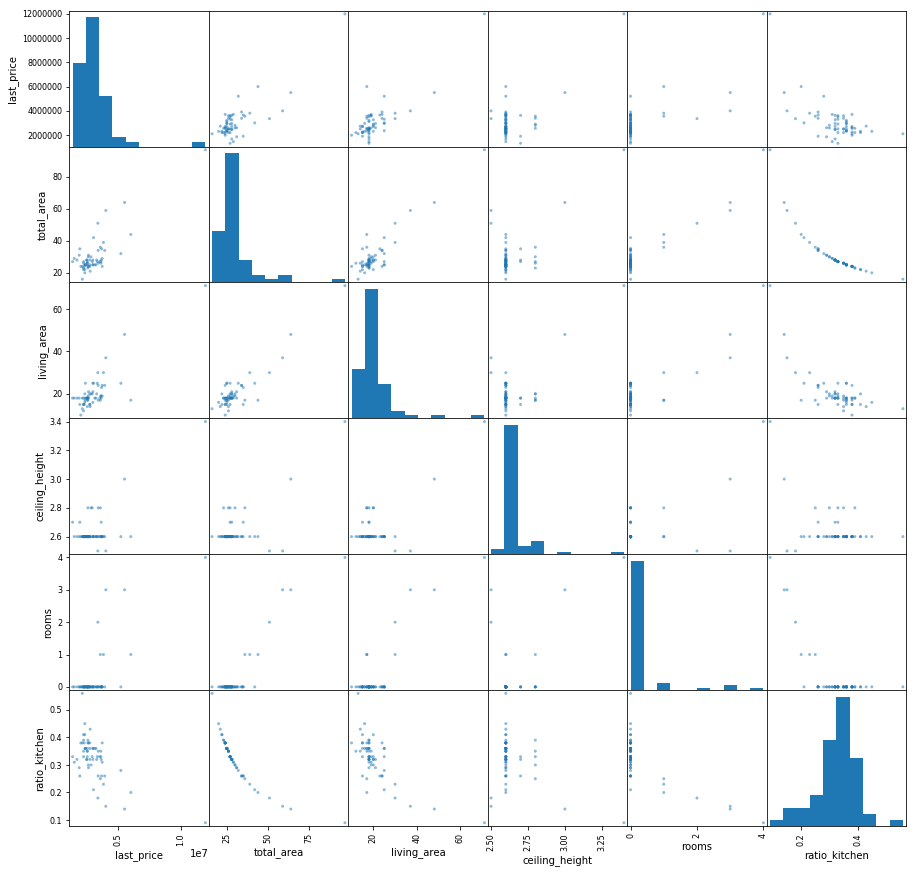

In [294]:
plot = pd.plotting.scatter_matrix(open_plan[['last_price', 'total_area','living_area', 'ceiling_height', 'rooms', 'ratio_kitchen']], figsize=(15,15))

Типичная квартира свободной планировки это квартира без комнаты площадью 27 метров с высотой потолков 2,6 метров, на 7 этаже 17-этажного дома с одним балконом, жилая площадь 68%, с кухней занимающей 33% площади квартиры. Цена за квадратный метр 100000 руб. и общая стоимость 2,7 млн руб. На удалении от центра в среднем на 19 км. Скорее всего это квартиры в новостройках в присоединенных не так давно развивающихся районах. Такая квартира продается очень быстро, в среднем за 45 дней.
*************
* На цену за квартиру свободной планировки влияют: общая и жилая площадь, количество комнат, близость к центру, так же выявлена отрицательная корреляция с соотношением кухни - не понимаю, что это значит?
* Цена за квадратный метр  имеет отрицательную корреляцию с центром города  - не понимаю?.

In [295]:
rest = data.query('is_apartment != True and studio != True and open_plan != True')
print(rest.median())

report6 = rest.corr()[['last_price', 'price_square_meter']]
report6.query('abs(last_price) > 0.5 or abs(price_square_meter) > 0.5').sort_values(by = 'last_price', ascending = False)

total_images                 10.00
last_price              4670000.00
total_area                   52.00
rooms                         2.00
ceiling_height                2.60
floors_total                  9.00
living_area                  30.00
floor                         4.00
studio                        0.00
open_plan                     0.00
kitchen_area                  9.00
balcony                       0.00
airports_nearest             26.00
city_centers_nearest         14.00
parks_around_3000             0.00
parks_nearest                 0.00
ponds_around_3000             0.00
ponds_nearest                 0.00
days_exposition             101.00
public_weekday                2.00
public_month                  6.00
public_year                2017.00
price_square_meter        95454.00
ratio_square                  0.57
ratio_kitchen                 0.17
dtype: float64


,last_price,price_square_meter
last_price,1.000000,0.747851
price_square_meter,0.747851,1.000000
total_area,0.640024,0.305546
living_area,0.563360,0.223843


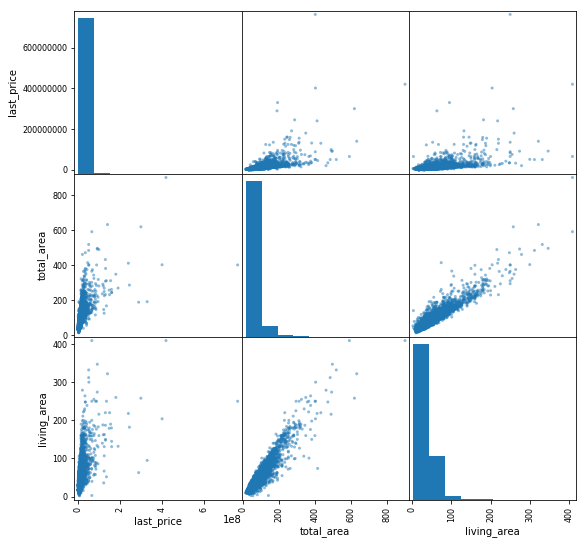

In [296]:
plot = pd.plotting.scatter_matrix(rest[['last_price', 'total_area','living_area']], figsize=(9,9))

Типичная квартира типовой планировки это двухкомнатная квартира площадью 52 метра с высотой потолков 2,6 метра, на 4 этаже 9-этажного дома без балкона, жилая площадь 57%, с кухней занимающей 17% общей площади. Цена за квадратный метр 95454 руб. и общая стоимость 4670000 млн руб. На удалении от центра в среднем на 14 км. Такие квартиры продаются в среднем за 101 день.
***************
* На цену типовых квартир влияют: общая и жилая площадь, так же выявлена корреляция с ценой за квадратный метр.

Практически все квартиры отмеченные True в категориях апартаменты, студии и квартиры свободной планировки попали в выбросы, вследствии неправильно указанных параметров или крайне высокой цены. **Обратить внимание коллег, какова причина?!!** 

### 3. Общие выводы.  <a id='100103'></a>

**Возникшие проблемы:**

* Данные в таблице за 5 лет с 2014 по 2019 включительно.
* пропущенные значения в столбцах city_centers_nearest, locality_name, parks_around_3000, parks_nearest, ponds_around_3000, ponds_nearest, airports_nearest, days_exposition - требуют внимания т.к. они добавляются автоматически на основе картографических данных, следовательно на каком-то этапе произошел сбой;
* колонка locality_name оказалась незаполненной в 49 случаях, хоть это и немного, но нужно обратить на это внимание!!;
* также выявлены неслучайные, а специально искаженные данные внесенные пользователями, конкретно высота потолков - в части из этих значений явно просто не проставлена запятая в дроби, а части похоже на умышленное искажение данных для этого можно сделать на сайте кнопки с вариантами высоты;
* много и случайных пропусков: balkony, ceiling_height, floors_total, kitchen_area, living_area, возможно пользователи поленились их заполнить так же возможно сделать кнопки с вариантами количества для некоторых пунктов;
* был дубликат столбца total_area;
* столбец building_series_id понятно конечно, что он указывает на серию дома и вообще тип строительства, но много непонятной информации в нем и много пропущенных строк, нужно уточнить каким образом и кем происходило заполнение.
* Возможно ввести систему при которой автоматически будет рассчитываться стоимость за квадратный метр, и при сильных колебаниях не допускать добъявление к публикации.

<font color='green'>* **2 Типичными параметрами квартир являются: населенный пункт, общая стоимость, цена за квадратный метр, общая площадь, жилая площадь, высота потолков, количество комнат, этаж, расстояние до центра города, наиболее важные характеристики для исследования это те же пункты плюс количество дней за которые продали квартиру. Цена квартиры до 11500000 руб., комнаты от 1 до 6,  дом до 17 этажей, общей площадью от 15 до 120 метров, жилая от 0 до 80 метров, цена квадратного метра от 23000 до 170000 руб, высота потолков от 2,5 м до 2,8 метров; расстояние от центра - до 32 км.**
* **Чем выше цена за кв.м тем больше общая и жилая площадь жилья, в более высоких домах квартиры дешевле, основная масса жилья это метраж от 15 до 120 кв.м (жилая до 80 кв.м) стоимостью до 170000 р/кв.м, высота потолков от 2,5 до 2,8 м,  стоимость выше за дома до 10 этажей, основная масса квартир продается в пределах 32 км от центра города, ну и конечно близость к центру удорожает квадратный метр.**

#### ВЛИЯНИЕ НА стоимость квадратного метра:
* **Ниже всего стоимость квартир на первом этаже, следом идут последние этажи. Вывод - все хотят жить посередине)).**
* **Чем больше комнат тем дешевле квадратный метр жилья.**
* **Есть явная зависимость стоимости кв.м от удалености от центра, 1 кв.м жилья в пределах 10 км. от центра стоит в среднем в 2-2,5 раза дороже жилья на удалении 20 км и более.**
* **Особенной связи между ценой кв.м и днем недели не наблюдается, только лишь в воскресенье цена немного ниже. Месяцы тоже не показывают ничего особенного, немного ниже цены в июне, декабре, немного выше в январе и марте.** 
* **Самые низкие цены за кв/м были в 2014 году, резкий рост в 2015, с 2015 по 2017 включительно на том же уровне и с 2018 начался рост.**</font>

#### Стоимость жилья в пригороде Санкт-Петербурга:
* **Средняя стоимость квадратного метра в ближайшем пригороде Санкт-Петербурга составляет 66600 р/м., а в городе средняя цена за метр - 95000 р., что на 30% больше, если взять населенные пункты за пределами городов с самым большим количеством предложений, то стоимость кв.м меняется еще сильнее и составляет уже примерно 55000 р/кв.м.**

#### Влияют ли на цену наиболее характерные параметры для апартаментов, студий, квартир свободной планировки и типовой планировки?

* **Типичные апартаменты это двухкомнатная квартира площадью 58 метров с высотой потолков 3 метра, на 4 этаже 5-этажного дома с одним балконом, жилая площадь 55%, где кухня занимает 19% площади квартиры. Цена за квадратный метр 116129 руб. и общая стоимость 6,9 млн руб. На удалении от центра в среднем на 19 км. Скорее всего это квартиры в новостройках в присоединенных не так давно развивающихся районах. В среднем продается такая квартира за 101 день (возможно есть взаимосвязь с выбросом выше). Так же выявлена странная зависимость общей площади и этажа проданной квартиры. (Нуждается в уточнении!!)**

* **Типичная студия это квартира без комнат площадью 26 метров с высотой потолков 2,6 метра, на 7 этаже 17-этажного дома с одним балконом, жилая площадь 68%, с кухней занимающей 35% общей площади. Цена за квадратный метр 108347 руб. и общая стоимость 2775000 руб. На удалении от центра в среднем на 16 км. Эти квартиры в среднем ближе к центру. Такая квартира довольно быстро продается - в среднем за 2 месяца. Здесь выявлена явная зависимость стоимости квадратного метра от этажа на котором находится квартира.**

* **Типичная квартира свободной планировки это квартира без комнаты площадью 27 метров с высотой потолков 2,6 метров, на 7 этаже 17-этажного дома с одним балконом, жилая площадь 68%, с кухней занимающей 33% площади квартиры. Цена за квадратный метр 100000 руб. и общая стоимость 2,7 млн руб. На удалении от центра в среднем на 19 км. Скорее всего это квартиры в новостройках в присоединенных не так давно развивающихся районах. Такая квартира продается очень быстро, в среднем за 45 дней. Выявлена небольшая связь между общей площадью и близостью к центру.**

* **Типичная квартира типовой планировки это двухкомнатная квартира площадью 52 метра с высотой потолков 2,6 метра, на 4 этаже 9-этажного дома без балкона, жилая площадь 57%, с кухней занимающей 17% общей площади. Цена за квадратный метр 95454 руб. и общая стоимость 4670000 млн руб. На удалении от центра в среднем на 14 км. Такие квартиры продаются в среднем за 101 день.**

* *Практически все квартиры отмеченные True в категориях апартаменты, студии и квартиры свободной планировки попали в выбросы, вследствии неправильно указанных параметров или крайне высокой цены. Обратить внимание, какова причина!? Возможно не стоит проводить деление по этим параметру, или проследить почему возникает сбой.*